# Genomic surveillance analysis in Germany

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpyro as npy
import numpyro.distributions as dist
import pandas as pd
from jax import random
import geopandas as gpd
import genomicsurveillance as gs ## misc branch on github

assert npy.__version__.startswith("0.8.0")
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'axes.grid': True,
                     'grid.linestyle': ':',
                     'axes.spines.bottom': False,
          'axes.spines.left': False,
          'axes.spines.right': False,
          'axes.spines.top': False})

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)


In [2]:
from genomicsurveillance.misc import ancestor_matrix, alias

## Download data
### Map
With zip codes for geo matching

In [3]:
#plz = gpd.read_file("https://opendata.arcgis.com/datasets/5b203df4357844c8a6715d7d411a8341_0.geojson")
if 'plz' not in locals():
    plz = gpd.read_file("data/5b203df4357844c8a6715d7d411a8341_0.geojson")
    bland = plz.set_index("plz")['bundesland']

### Sequences
From RKI's Github

In [4]:
! bash scripts/pipeline.sh

+ bash scripts/download_data.sh
+ mkdir -p data/compressed
+ curl -L https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland/raw/master/SARS-CoV-2-Sequenzdaten_Deutschland.csv.xz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 60.9M  100 60.9M    0     0  7859k      0  0:00:07  0:00:07 --:--:-- 13.3M
+ curl -L https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland/raw/master/SARS-CoV-2-Entwicklungslinien_Deutschland.csv.xz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 23.0M  100 23.0M    0     0  6243k      0  0:00:03  0:00:03 --:--:--  9.9M
+ bash scripts/

In [5]:
df = pd.read_csv(
    'data/meta_lineages.csv',
    index_col=0,
    parse_dates=[1,3],
    infer_datetime_format=True,
    cache_dates=True,
    dtype = {'SEQ_REASON': 'category',
             'SENDING_LAB_PC': 'category',
             'SEQUENCING_LAB_PC': 'category',
             'lineage': 'category',
             'scorpio_call': 'category'
             }
)
df.rename(columns={
    'DATE_DRAW': 'date',
    'PROCESSING_DATE': 'processing_date',
    'SEQ_REASON': 'reason',
    'SENDING_LAB_PC': 'sending_pc',
    'SEQUENCING_LAB_PC': 'sequencing_pc',
    'lineage': 'lineage',
    'scorpio_call': 'scorpio'
    },
    inplace=True
)

In [6]:
df = df[~ pd.isna(df.sending_pc)]
df.sending_pc = df.sending_pc.cat.rename_categories({x:f"{float(x):05.0f}" for x in df.sending_pc.cat.categories}) # = df.sending_pc.astype('str').astype('category')


In [7]:

df = df.merge(bland, left_on='sending_pc', right_index=True)#.dropna()


In [8]:
df.reason.value_counts()

N                             583739
X                             339271
Y                              39398
A[B.1.617.2]                   35860
A[B.1.1.7]                     35832
                               ...  
A[E484K/N501Y/P681R]               0
A[E484E/N501N/P681P]               0
A[N501Y/E484K]                     0
A[KONTAKTMITENGL.MUTATION]         0
A[E484E/N501N/P681R]               0
Name: reason, Length: 232, dtype: int64

In [9]:
import re

In [10]:
df

,date,reason,processing_date,sending_pc,sequencing_pc,lineage,scorpio,bundesland
IMS_ID,,,,,,,,
IMS-10294-CVDP-00001,2021-01-14,X,2021-01-25,40225,40225,B.1.1.297,NaN,Nordrhein-Westfalen
IMS-10294-CVDP-00325,2020-11-08,X,2021-02-14,40225,40225,B.1.221,NaN,Nordrhein-Westfalen
IMS-10294-CVDP-00326,2020-11-08,X,2021-02-14,40225,40225,B.1.160,NaN,Nordrhein-Westfalen
IMS-10294-CVDP-00327,2020-11-08,X,2021-02-14,40225,40225,B.1.258,NaN,Nordrhein-Westfalen
IMS-10294-CVDP-00329,2020-11-09,X,2021-02-14,40225,40225,B.1.1.521,NaN,Nordrhein-Westfalen
...,...,...,...,...,...,...,...,...
IMS-10594-CVDP-CE8299E7-659A-476E-B2A2-5DBB2BCDE01B,2022-08-23,Y,2022-09-21,55131,55131,BA.5.1.2,NaN,Rheinland-Pfalz
IMS-10594-CVDP-76A84CA4-0B43-4F05-BEED-F76CF7F9442A,2022-08-30,Y,2022-09-21,55131,55131,BA.5.1,NaN,Rheinland-Pfalz
IMS-10594-CVDP-45DCC9DB-98F1-4770-896C-8CAE1C401AF3,2022-08-30,Y,2022-09-21,55131,55131,BA.5.1.2,NaN,Rheinland-Pfalz


In [11]:
df.lineage[df.date > np.datetime64("today") - np.timedelta64(30, "D")].cat.remove_unused_categories().value_counts()

BA.5.2      3631
BA.5.1      2731
BA.5.2.1    1914
BE.1.1      1394
BF.7         882
            ... 
BA.5.2.7       1
BA.5.1.9       1
BA.5.1.8       1
BA.2.3.7       1
BK.1           1
Name: lineage, Length: 95, dtype: int64

In [12]:
start_date = "2021-01-01"
d = df.loc[df.date >= start_date,:]
d = d[d.reason.isin(['N','X'])]
d = d[d.lineage != "None"]
d.lineage = d.lineage.cat.remove_unused_categories().cat.add_categories(['Other'])
l = d.lineage.cat.categories#remove_unused_categories()

In [13]:
ba = [x for x in l if alias(x, anti_alias=True).startswith('B.1.1.529') ]
#ba

In [14]:
#d.lineage[d.lineage.isna()] = 'Other'
#d.loc[~d.lineage.isin(['BA.1','BA.1.1','BA.2','BA.3','B.1.1.529']),"lineage"] = "Delta/Other"
#d.lineage.iloc[d.lineage.apply(lambda x: re.match("AY",x) is not None).astype("Bool")] = "B.1.617.2"
#d.loc[~d.lineage.isin(['BA.1','BA.1.1','BA.2','BA.3','B.1.1.529','B.1.617.2'] + ba),"lineage"] = "Other"
d.lineage = d.lineage.cat.remove_unused_categories()#.cat.add_categories(['BA.2.40'])
genomes = pd.crosstab(index=[d.bundesland, d.date], columns=d.lineage, dropna=False).fillna(0)
#genomes.loc["Baden-Württemberg"]
genomes = genomes.iloc[:,[(i + 1) % genomes.shape[1] for i in range(genomes.shape[1])]]
genomes

lineage                       A.19  A.2.5  A.2.5.2  A.23.1  A.27  A.28  A.29  \
bundesland        date                                                         
Baden-Württemberg 2021-01-01     0      0        0       0     0     0     0   
                  2021-01-02     0      0        0       0     0     0     0   
                  2021-01-03     0      0        0       0     0     0     0   
                  2021-01-04     0      0        0       0     0     0     0   
                  2021-01-05     0      0        0       0     0     0     0   
...                            ...    ...      ...     ...   ...   ...   ...   
Thüringen         2022-09-17     0      0        0       0     0     0     0   
                  2022-09-18     0      0        0       0     0     0     0   
                  2022-09-19     0      0        0       0     0     0     0   
                  2022-09-20     0      0        0       0     0     0     0   
                  2022-09-22     0      0        0       0     0     0     0   

lineage                       AA.1  AF.1  AG.1  ...  BA.5.2.5  BA.5.6.1  \
bundesland        date                          ...                       
Baden-Württemberg 2021-01-01     0     0     0  ...         0         0   
                  2021-01-02     0     0     0  ...         0         0   
                  2021-01-03     0     0     0  ...         0         0   
                  2021-01-04     0     0     0  ...         0         0   
                  2021-01-05     0     0     0  ...         0         0   
...                            ...   ...   ...  ...       ...       ...   
Thüringen         2022-09-17     0     0     0  ...         0         0   
                  2022-09-18     0     0     0  ...         0         0   
                  2022-09-19     0     0     0  ...         0         0   
                  2022-09-20     0     0     0  ...         0         0   
                  2022-09-22     0     0     0  ...         0         0   

lineage                       BE.1.2  BF.13  BF.9  BH.1  BK.1  XAJ  BA.2.10.4  \
bundesland        date                                                          
Baden-Württemberg 2021-01-01       0      0     0     0     0    0          0   
                  2021-01-02       0      0     0     0     0    0          0   
                  2021-01-03       0      0     0     0     0    0          0   
                  2021-01-04       0      0     0     0     0    0          0   
                  2021-01-05       0      0     0     0     0    0          0   
...                              ...    ...   ...   ...   ...  ...        ...   
Thüringen         2022-09-17       0      0     0     0     0    0          0   
                  2022-09-18       0      0     0     0     0    0          0   
                  2022-09-19       0      0     0     0     0    0          0   
                  2022-09-20       0      0     0     0     0    0          0   
                  2022-09-22       0      0     0     0     0    0          0   

lineage                       A  
bundesland        date           
Baden-Württemberg 2021-01-01  0  
                  2021-01-02  0  
                  2021-01-03  0  
                  2021-01-04  0  
                  2021-01-05  0  
...                          ..  
Thüringen         2022-09-17  0  
                  2022-09-18  0  
                  2022-09-19  0  
                  2022-09-20  0  
                  2022-09-22  0  

[10064 rows x 711 columns]

In [15]:
with pd.option_context('display.max_rows', None,):
    print(genomes.sum(level=1).loc["2022-06-01":,[x for x in genomes.columns if x.startswith("BA.2.75")]])

lineage     BA.2.75  BA.2.75.1  BA.2.75.2  BA.2.75.5
date                                                
2022-06-01        0          0          0          0
2022-06-02        0          0          0          0
2022-06-03        1          0          0          0
2022-06-04        0          0          0          0
2022-06-05        0          0          0          0
2022-06-06        1          0          0          0
2022-06-07        0          0          0          0
2022-06-08        0          0          0          0
2022-06-09        0          0          0          0
2022-06-10        0          0          0          0
2022-06-11        0          0          0          0
2022-06-12        0          0          0          0
2022-06-13        0          0          0          0
2022-06-14        0          0          0          0
2022-06-15        0          0          0          0
2022-06-16        0          0          0          0
2022-06-17        0          0          0     

Text(0, 0.5, '14d log odds Aug 1-15 / Jul 15-30')

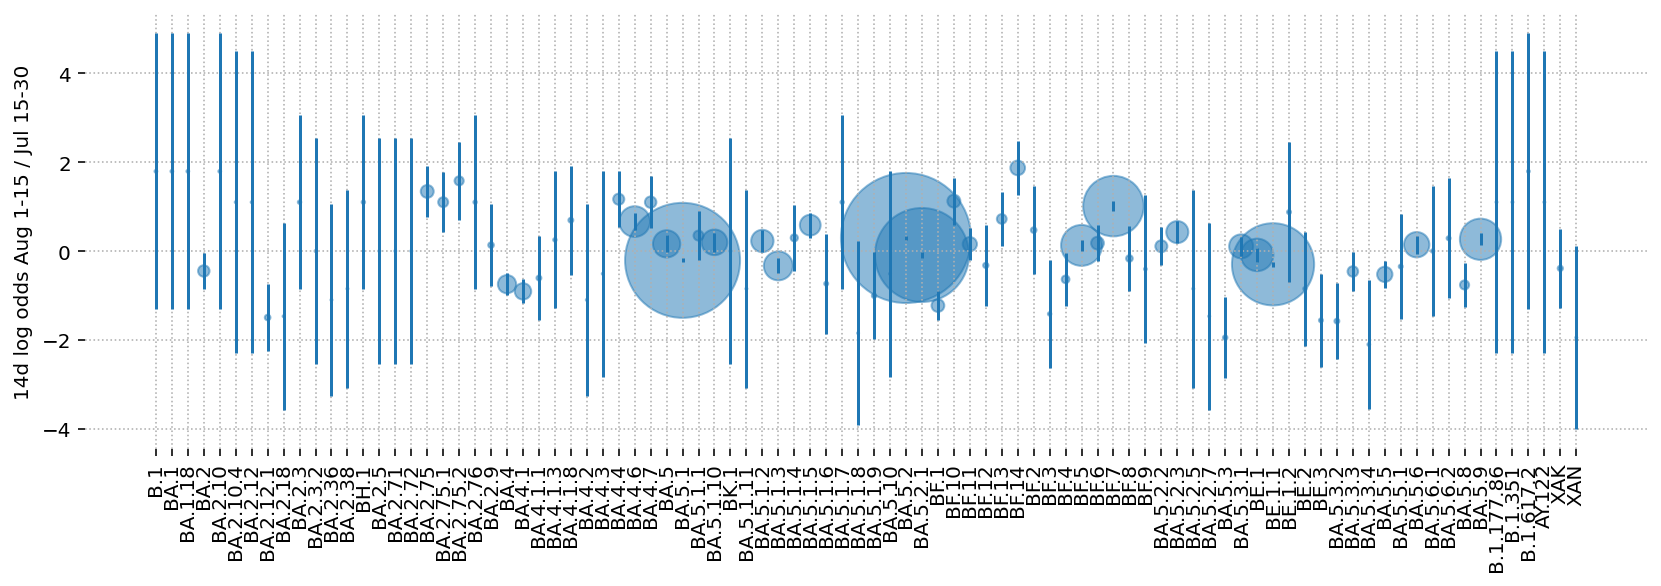

In [16]:
g = genomes.sum(level=1)
g.columns =  [alias(alias(x, anti_alias=True)) for x in g.columns]
h = g.iloc[-28:].sum(0) #+.5
i = g.iloc[-56:-28].sum(0) +.5
f = h[h>0]/i[h>0] * i.sum()/h.sum()
f.index = [alias(x, anti_alias=True) for x in f.index]
f = f.sort_index()
f.index = [alias(x) for x in f.index]
n = h[h>0]
e = np.sqrt(1./h[h>0] + 1./i[h>0] + 1./i.sum() + 1./h.sum())
#e.index = [alias(alias(x, anti_alias=True)) for x in e.index]
plt.figure(figsize=(14,4))
plt.scatter(f.index, np.log(f), s=n[f.index], alpha=0.5)
plt.errorbar(f.index, np.log(f), yerr=1.96*e[f.index], ls="")
_ = plt.xticks(rotation=90)
plt.ylabel("14d log odds Aug 1-15 / Jul 15-30")

Text(0, 0.5, 'Fold change')

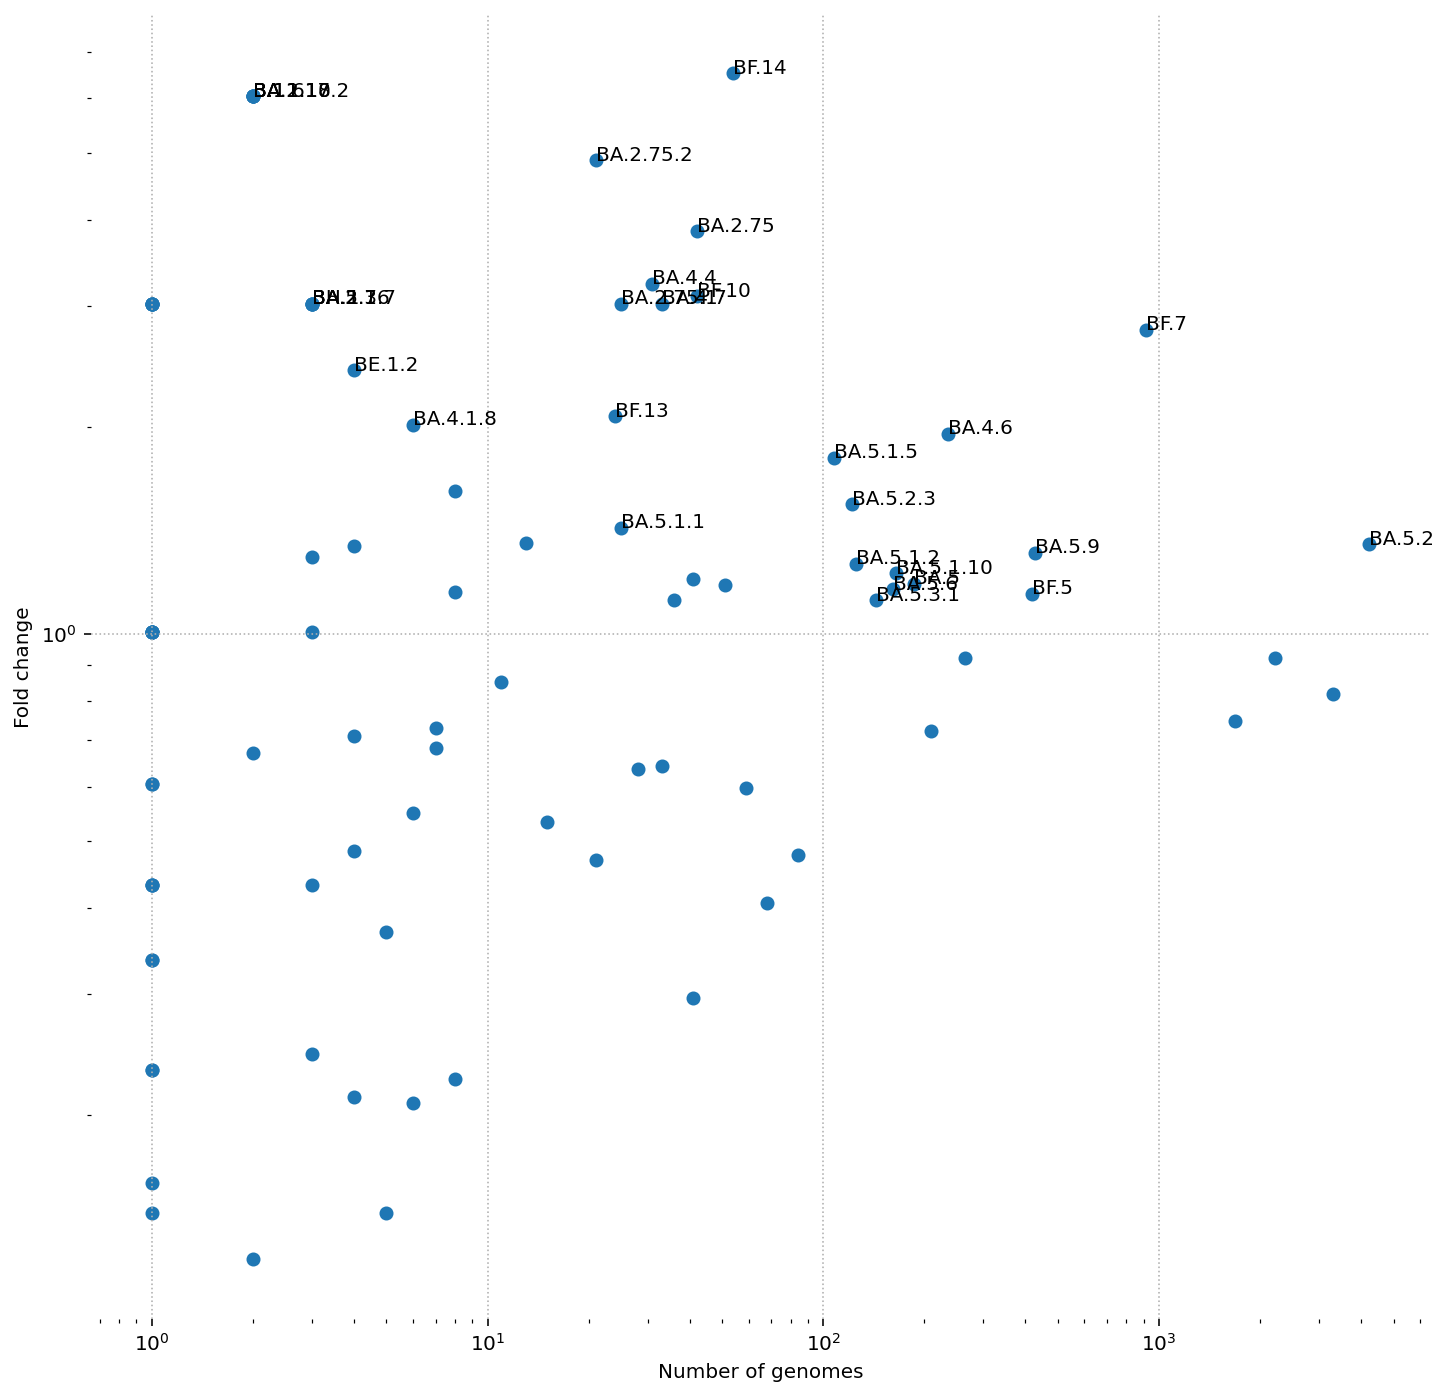

In [17]:
plt.figure(figsize=(12,12))
plt.scatter(n[f.index],f)
for l in f.index:
    if np.log(f[l]) > e[l]:
        plt.text(x=n[l], y=f[l], s=l)
plt.yscale('log')
plt.xlabel("Number of genomes")
plt.xscale('log')
plt.ylabel("Fold change")

(19083.0, 19288.45)

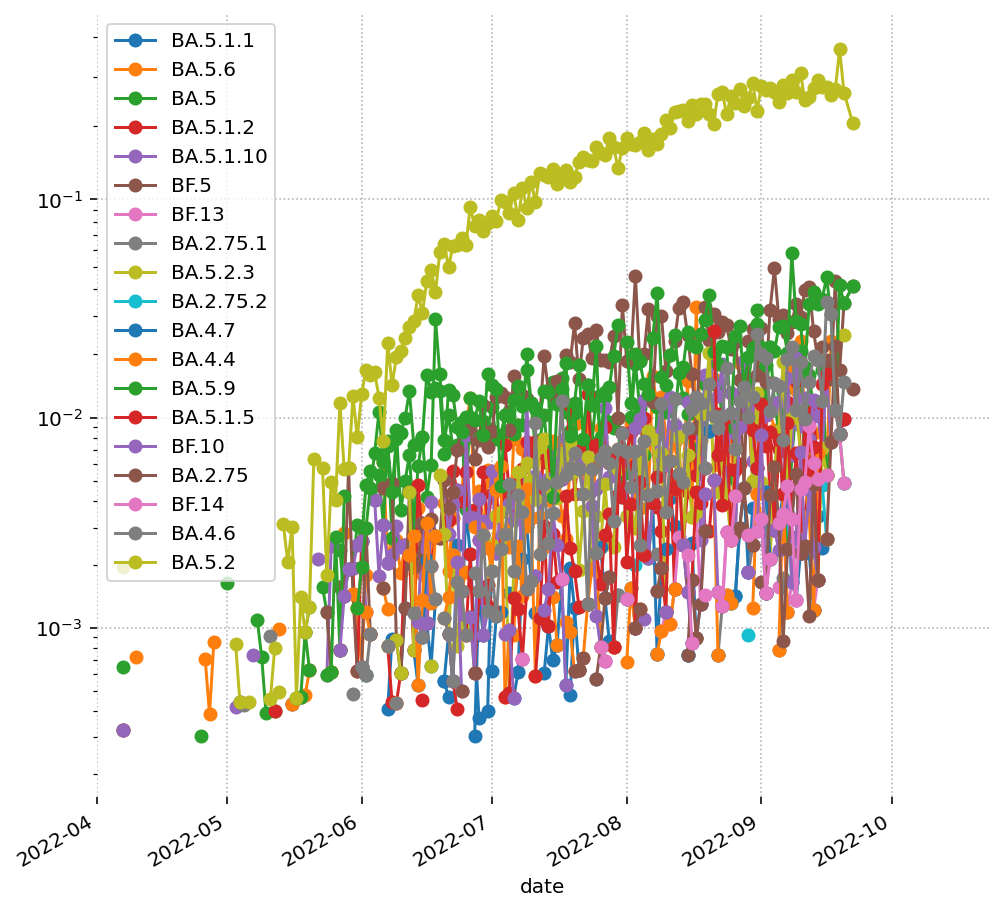

In [18]:
plt.figure(figsize=(8,8))
plt.set_cmap('tab20')
for i,v in enumerate((np.log(f)/e[f.index]).sort_values()[-20:-1].index.to_list() ):
    if g[v].sum()>=20:
        (g[v]/g.sum(1)+0).plot(label=v, ls="-", marker="o")
plt.yscale('logit')
#plt.show()
plt.legend()
plt.xlim(("2022-04-01",None))

In [19]:
url = "https://dev-lapis.cov-spectrum.org/gisaid/v1/sample/aggregated?country=Germany&dateFrom=2022-06-20&nextcladePangoLineage=bq.1*&aaMutations=S%3A346T&host=Human&accessKey=9Cb3CqmrFnVjO3XCxQLO6gUnKPd&fields=date"
import json, requests
foo = json.loads(requests.get(url).text)['data']
foo

[{'date': '2022-08-24', 'count': 1}]

In [20]:
url = "https://dev-lapis.cov-spectrum.org/gisaid/v1/sample/aggregated?country=Germany&dateFrom=2022-06-20&nextcladePangoLineage=ba.2.3.20&host=Human&accessKey=9Cb3CqmrFnVjO3XCxQLO6gUnKPd&fields=date"
import json, requests
foo = json.loads(requests.get(url).text)['data']
foo

[]

In [21]:
genomes.loc["Sachsen", "2022-02-20"]["BA.4"] = 0 ## Remove outlier

In [22]:
genomes.index.levels[0]

Index(['Baden-Württemberg', 'Bayern', 'Berlin', 'Brandenburg', 'Bremen',
       'Hamburg', 'Hessen', 'Mecklenburg-Vorpommern', 'Niedersachsen',
       'Nordrhein-Westfalen', 'Rheinland-Pfalz', 'Saarland', 'Sachsen',
       'Sachsen-Anhalt', 'Schleswig-Holstein', 'Thüringen'],
      dtype='object', name='bundesland')

In [23]:
genomes.loc[:,"BA.2.75"].sum(level=0)

bundesland
Baden-Württemberg         25
Bayern                    11
Berlin                     2
Brandenburg                2
Bremen                     0
Hamburg                    2
Hessen                     0
Mecklenburg-Vorpommern     2
Niedersachsen              7
Nordrhein-Westfalen       10
Rheinland-Pfalz            2
Saarland                   1
Sachsen                    4
Sachsen-Anhalt             0
Schleswig-Holstein         2
Thüringen                  0
Name: BA.2.75, dtype: int64

In [24]:
import importlib
importlib.reload(gs.utils)
importlib.reload(gs)
from genomicsurveillance.utils import preprocess_lineage_tensor

In [25]:
G = genomes.values.reshape([len(genomes.index.levels[0]), len(genomes.index.levels[1]), -1])

In [26]:
lineages = genomes.columns.to_list()

In [27]:
pattern=re.compile(r"[A-Z]+(\.\d+)*$")
pattern.match(lineages[1])

<re.Match object; span=(0, 5), match='A.2.5'>

In [28]:
foo =d.lineage.value_counts()[:200]
bar = [d.date[d.lineage==l].sort_values()[10] for l in foo.index]
bak = pd.DataFrame({'counts':foo, 'date':bar})

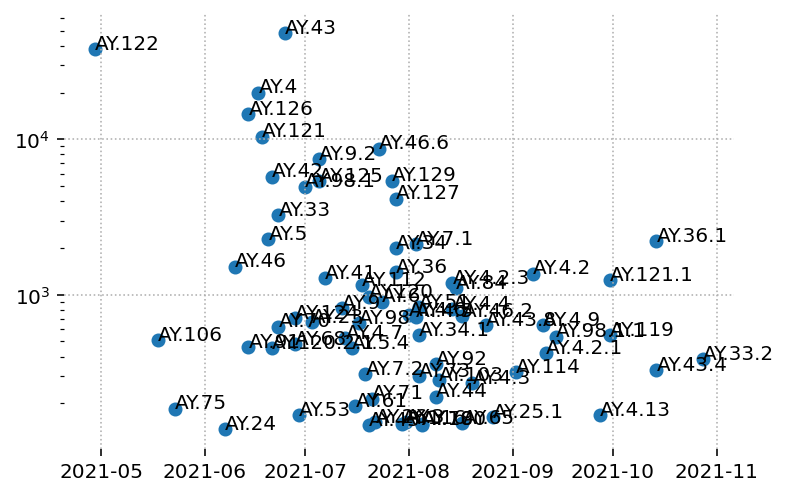

In [29]:
ay = bak.loc[bak.index.str.match('AY')]
plt.scatter(ay.date, ay.counts)
for i in ay.index:
    plt.text(bak.date[i], bak.counts[i], i)
plt.yscale('log')

In [30]:
vocs = ["B.1.1.529","BA.1","BA.1.1","BA.2","BA.4","BA.5","BA.5.2","BA.2.12.1","BA.2.75", "BA.2.75.1","BA.2.75.2","BA.4.6", "BF.7", "BF.11", "BF.13", "BF.14"] + ["B.1.1.7","B.1.1.318","B.1.621","B.1.525","B.1.351","P.1","AY.43","AY.46.6","AY.4.2","AY.36.1"]

In [31]:
merged_lineages, G, _ = preprocess_lineage_tensor(lineage_tensor=G, 
                                                     lineage_list=[alias(x, anti_alias=True) for x in lineages], 
                                                     vocs=[alias(x, anti_alias=True) for x in lineages if x in vocs], #any([y in x for y in ["BA.4","BA.5","BA.2.12.1"]])], 
                                                     cutoff=100000)
merged_lineages

Dropped lineages []


['A',
 'B',
 'B.1.1.7',
 'B.1.1.28.1',
 'B.1.1.318',
 'B.1.1.529',
 'B.1.1.529.1',
 'B.1.1.529.1.1',
 'B.1.1.529.2',
 'B.1.1.529.2.12.1',
 'B.1.1.529.2.75',
 'B.1.1.529.2.75.1',
 'B.1.1.529.2.75.2',
 'B.1.1.529.4',
 'B.1.1.529.4.6',
 'B.1.1.529.5',
 'B.1.1.529.5.2',
 'B.1.1.529.5.2.1.7',
 'B.1.1.529.5.2.1.11',
 'B.1.1.529.5.2.1.13',
 'B.1.1.529.5.2.1.14',
 'B.1.351',
 'B.1.525',
 'B.1.617.2',
 'B.1.617.2.4.2',
 'B.1.617.2.36.1',
 'B.1.617.2.43',
 'B.1.617.2.46.6',
 'B.1.621',
 'XAB',
 'XAD',
 'XAF',
 'XAG',
 'XAH',
 'XAJ',
 'XAK',
 'XAL',
 'XAM',
 'XAN',
 'XAP',
 'XAS',
 'XAU',
 'XB',
 'XD',
 'XE',
 'XG',
 'XH',
 'XJ',
 'XM',
 'XV',
 'XW',
 'XZ']

In [32]:
G.sum((0,1))

array([6.93000e+02, 3.10850e+04, 9.77030e+04, 9.23000e+02, 1.17300e+03,
       1.52600e+03, 5.74280e+04, 1.09756e+05, 2.59643e+05, 3.82700e+03,
       7.10000e+01, 3.90000e+01, 2.70000e+01, 6.31000e+03, 6.34000e+02,
       7.14830e+04, 3.43360e+04, 1.67300e+03, 1.38000e+02, 4.20000e+01,
       7.00000e+01, 1.97900e+03, 8.60000e+02, 1.75418e+05, 3.09900e+03,
       2.22100e+03, 4.91790e+04, 8.70100e+03, 1.65000e+02, 1.26000e+02,
       9.00000e+01, 2.00000e+00, 5.00000e+00, 5.00000e+00, 1.00000e+00,
       1.26000e+02, 9.70000e+01, 6.00000e+00, 2.50000e+01, 1.00000e+00,
       1.00000e+00, 2.00000e+00, 5.00000e+00, 1.00000e+00, 4.90000e+01,
       4.60000e+01, 3.00000e+00, 1.00000e+00, 3.75000e+02, 1.00000e+00,
       5.30000e+01, 3.00000e+00])

In [33]:
baseline = 'B'
o = [merged_lineages.index(x) for x in merged_lineages if x != baseline and not x.startswith("X")] + [merged_lineages.index(baseline)]
G = G[:,:,o]
merged_lineages = [merged_lineages[x] for x in o]
merged_lineages

['A',
 'B.1.1.7',
 'B.1.1.28.1',
 'B.1.1.318',
 'B.1.1.529',
 'B.1.1.529.1',
 'B.1.1.529.1.1',
 'B.1.1.529.2',
 'B.1.1.529.2.12.1',
 'B.1.1.529.2.75',
 'B.1.1.529.2.75.1',
 'B.1.1.529.2.75.2',
 'B.1.1.529.4',
 'B.1.1.529.4.6',
 'B.1.1.529.5',
 'B.1.1.529.5.2',
 'B.1.1.529.5.2.1.7',
 'B.1.1.529.5.2.1.11',
 'B.1.1.529.5.2.1.13',
 'B.1.1.529.5.2.1.14',
 'B.1.351',
 'B.1.525',
 'B.1.617.2',
 'B.1.617.2.4.2',
 'B.1.617.2.36.1',
 'B.1.617.2.43',
 'B.1.617.2.46.6',
 'B.1.621',
 'B']

In [34]:
merged_lineages_alias = [alias(x) for x in merged_lineages]
merged_lineages_alias

['A',
 'B.1.1.7',
 'P.1',
 'B.1.1.318',
 'B.1.1.529',
 'BA.1',
 'BA.1.1',
 'BA.2',
 'BA.2.12.1',
 'BA.2.75',
 'BA.2.75.1',
 'BA.2.75.2',
 'BA.4',
 'BA.4.6',
 'BA.5',
 'BA.5.2',
 'BF.7',
 'BF.11',
 'BF.13',
 'BF.14',
 'B.1.351',
 'B.1.525',
 'B.1.617.2',
 'AY.4.2',
 'AY.36.1',
 'AY.43',
 'AY.46.6',
 'B.1.621',
 'B']

In [35]:
dict(zip(merged_lineages_alias,G.sum((0,1))))

{'A': 693.0,
 'B.1.1.7': 97703.0,
 'P.1': 923.0,
 'B.1.1.318': 1173.0,
 'B.1.1.529': 1526.0,
 'BA.1': 57428.0,
 'BA.1.1': 109756.0,
 'BA.2': 259643.0,
 'BA.2.12.1': 3827.0,
 'BA.2.75': 71.0,
 'BA.2.75.1': 39.0,
 'BA.2.75.2': 27.0,
 'BA.4': 6310.0,
 'BA.4.6': 634.0,
 'BA.5': 71483.0,
 'BA.5.2': 34336.0,
 'BF.7': 1673.0,
 'BF.11': 138.0,
 'BF.13': 42.0,
 'BF.14': 70.0,
 'B.1.351': 1979.0,
 'B.1.525': 860.0,
 'B.1.617.2': 175418.0,
 'AY.4.2': 3099.0,
 'AY.36.1': 2221.0,
 'AY.43': 49179.0,
 'AY.46.6': 8701.0,
 'B.1.621': 165.0,
 'B': 31085.0}

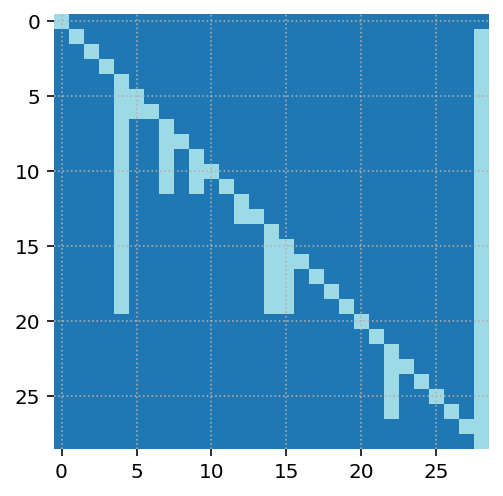

In [36]:
A = ancestor_matrix(merged_lineages)
plt.imshow(A)

In [37]:
#A[1:-1,merged_lineages.index("B.1.1.7")] = 1
#A[merged_lineages.index('B.1.1.529'):-4,merged_lineages.index("B.1.617.2")] = 1
#plt.imshow(A)

### Cases
Also from RKI

In [38]:
cases_raw = pd.read_csv("https://github.com/robert-koch-institut/SARS-CoV-2-Infektionen_in_Deutschland/blob/main/Aktuell_Deutschland_SarsCov2_Infektionen.csv?raw=true",  index_col=[0,1,2,4], parse_dates=True)

In [39]:
cases_raw

Meldedatum  \
IdLandkreis Altersgruppe Geschlecht Refdatum                 
1001        A15-A34      M          2020-01-19  2020-10-28   
                                    2020-03-13  2020-03-21   
                                    2020-03-13  2020-03-19   
                                    2020-03-16  2020-03-14   
                                    2020-03-16  2020-03-19   
...                                                    ...   
16077       A05-A14      W          2022-09-27  2022-09-27   
            A80+         W          2022-09-27  2022-09-27   
            A15-A34      W          2022-09-28  2022-09-28   
            A35-A59      W          2022-09-28  2022-09-28   
            A60-A79      W          2022-09-28  2022-09-28   

                                                IstErkrankungsbeginn  \
IdLandkreis Altersgruppe Geschlecht Refdatum                           
1001        A15-A34      M          2020-01-19                     1   
                                    2020-03-13                     1   
                                    2020-03-13                     1   
                                    2020-03-16                     1   
                                    2020-03-16                     1   
...                                                              ...   
16077       A05-A14      W          2022-09-27                     0   
            A80+         W          2022-09-27                     0   
            A15-A34      W          2022-09-28                     0   
            A35-A59      W          2022-09-28                     0   
            A60-A79      W          2022-09-28                     0   

                                                NeuerFall  NeuerTodesfall  \
IdLandkreis Altersgruppe Geschlecht Refdatum                                
1001        A15-A34      M          2020-01-19          0              -9   
                                    2020-03-13          0              -9   
                                    2020-03-13          0              -9   
                                    2020-03-16          0              -9   
                                    2020-03-16          0              -9   
...                                                   ...             ...   
16077       A05-A14      W          2022-09-27          1              -9   
            A80+         W          2022-09-27          1              -9   
            A15-A34      W          2022-09-28          1              -9   
            A35-A59      W          2022-09-28          1              -9   
            A60-A79      W          2022-09-28          1              -9   

                                                NeuGenesen  AnzahlFall  \
IdLandkreis Altersgruppe Geschlecht Refdatum                             
1001        A15-A34      M          2020-01-19           0           1   
                                    2020-03-13           0           1   
                                    2020-03-13           0           1   
                                    2020-03-16           0           1   
                                    2020-03-16           0           1   
...                                                    ...         ...   
16077       A05-A14      W          2022-09-27          -9           2   
            A80+         W          2022-09-27          -9           3   
            A15-A34      W          2022-09-28          -9           6   
            A35-A59      W          2022-09-28          -9           5   
            A60-A79      W          2022-09-28          -9           3   

                                                AnzahlTodesfall  AnzahlGenesen  
IdLandkreis Altersgruppe Geschlecht Refdatum                                    
1001        A15-A34      M          2020-01-19                0              1  
                                    2020-03-13                0              1  
               

### Registration delays

In [40]:
f = cases_raw.reset_index(level=3)[['Refdatum','Meldedatum','AnzahlFall'] ].reset_index()
f['Delta'] = np.clip(pd.to_datetime(f['Meldedatum']) - f['Refdatum'], np.timedelta64(0,"D"), np.timedelta64(10,"D"))
f['bundesland'] = (f.IdLandkreis/1000).astype("int")

f= f.set_index(["bundesland","IdLandkreis","Altersgruppe","Geschlecht","Refdatum","Delta"]).sum(level=[0,4,5]).sort_index()
f = f.unstack(level=2)["AnzahlFall"].sort_index().loc[:,"2022-02-01":,:]#.loc[:,"2021-11-01":]
f /= f.sum(1).values[:,np.newaxis]

<AxesSubplot:xlabel='bundesland,Refdatum'>

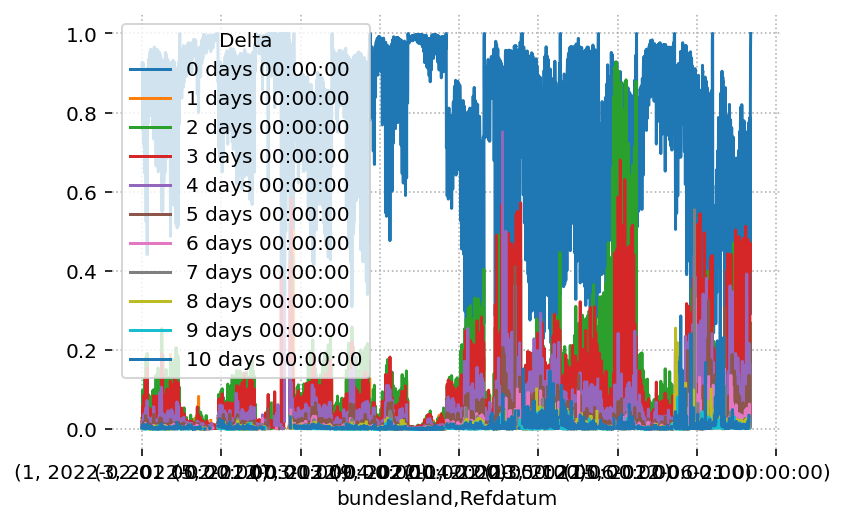

In [41]:
f.plot()

In [42]:
f['weekday'] = f.reset_index()['Refdatum'].dt.strftime("%a").values

In [43]:
f = f.reset_index().set_index(["bundesland","Refdatum","weekday"]).cumsum(1).mean(level=[0,2]).fillna(1)

In [44]:
f.loc[1]

Delta,0 days 00:00:00,1 days 00:00:00,2 days 00:00:00,3 days 00:00:00,4 days 00:00:00,5 days 00:00:00,6 days 00:00:00,7 days 00:00:00,8 days 00:00:00,9 days 00:00:00,10 days 00:00:00
weekday,,,,,,,,,,,
Tue,0.928204,0.951184,0.975394,0.988169,0.990973,0.991728,0.995892,0.997630,0.998507,0.998788,1.0
Wed,0.927131,0.949489,0.974856,0.980451,0.982784,0.991738,0.996035,0.997762,0.998463,0.999003,1.0
Thu,0.919220,0.945744,0.956281,0.962493,0.983119,0.992784,0.996452,0.997772,0.998430,0.998504,1.0
Fri,0.910955,0.921480,0.934138,0.964491,0.984481,0.992939,0.995399,0.997076,0.997355,0.996429,1.0
Sat,0.753093,0.776854,0.861292,0.940076,0.976468,0.986677,0.991541,0.992551,0.992503,0.995627,1.0
Sun,0.660847,0.742408,0.870565,0.945873,0.972513,0.985052,0.985789,0.987081,0.992978,0.995043,1.0
Mon,0.898850,0.926072,0.963571,0.981199,0.990257,0.992471,0.993017,0.995849,0.997291,0.998314,1.0


In [45]:
reporting_lag = np.array([f.loc[:,d.strftime("%a"),:].iloc[:,(cases_raw.index.levels[3][-1]-d).days] for d in cases_raw.index.levels[3][-9:]]).T

In [46]:
s="""01  Schleswig-Holstein
02  Hamburg
03  Niedersachsen
04  Bremen
05  Nordrhein-Westfalen
06  Hessen
07  Rheinland-Pfalz
08  Baden-Württemberg
09  Bayern
10  Saarland
11  Berlin
12  Brandenburg
13  Mecklenburg-Vorpommern
14  Sachsen
15  Sachsen-Anhalt
16  Thüringen"""
b={int(x.split()[0]): x.split()[1] for x in s.split("\n")}

In [47]:
current_lag = pd.DataFrame(reporting_lag, index=np.arange(1,17)).rename(index=b).sort_index()
current_lag

,0,1,2,3,4,5,6,7,8
Baden-Württemberg,0.999770,0.999625,0.999304,0.998883,0.995736,0.988130,0.994934,0.995105,0.993292
Bayern,0.995404,0.993373,0.988254,0.978781,0.941120,0.871596,0.874787,0.843562,0.804559
Berlin,0.990424,0.988423,0.982761,0.969448,0.882039,0.714344,0.916490,0.905012,0.902365
Brandenburg,0.994375,0.993431,0.989995,0.983354,0.941835,0.837349,0.947061,0.953785,0.938040
Bremen,0.998784,0.999236,0.998171,0.998440,0.991596,0.937813,0.985716,0.981993,0.989960
Hamburg,0.997383,0.996735,0.997223,0.995121,0.988041,0.982181,0.982140,0.981141,0.974849
Hessen,0.998701,0.998023,0.996045,0.994536,0.979086,0.934094,0.965333,0.953209,0.936480
Mecklenburg-Vorpommern,0.997953,0.997404,0.994975,0.993228,0.950282,0.935676,0.941272,0.864349,0.808321
Niedersachsen,0.996913,0.995912,0.994101,0.989228,0.970760,0.922757,0.951624,0.952864,0.938623
Nordrhein-Westfalen,0.996434,0.994896,0.991224,0.984405,0.960743,0.907219,0.921409,0.903711,0.867097


In [48]:
cases = cases_raw['AnzahlFall'].sum(level=(0,3)).sort_index()

In [49]:
cases_land = cases.reset_index()
cases_land['bundesland'] = (cases_land.IdLandkreis/1000).astype("int")
cases_land = cases_land.set_index(['bundesland', 'IdLandkreis','Refdatum']).sum(level=(0,2)).sort_index()
cases_land = cases_land.rename(index=b).sort_index()
cases_land = cases_land.loc[:,start_date:,:].unstack()["AnzahlFall"]#.iloc[:,:-1]
#cases_land.iloc[:,-9:] = (cases_land.iloc[:,-9:] / reporting_lag).astype("int32")
cases_land

Refdatum,2021-01-01,2021-01-02,2021-01-03,2021-01-04,2021-01-05,2021-01-06,2021-01-07,2021-01-08,2021-01-09,2021-01-10,...,2022-09-19,2022-09-20,2022-09-21,2022-09-22,2022-09-23,2022-09-24,2022-09-25,2022-09-26,2022-09-27,2022-09-28
bundesland,,,,,,,,,,,,,,,,,,,,,
Baden-Württemberg,1586,1666,1663,2042,2554,1964,2064,2250,1801,1381,...,5336,6046,5772,5563,5306,1493,780,9100,10529,63
Bayern,2152,2446,2221,2911,3605,3026,3271,3585,2642,1928,...,9714,10122,8565,8835,8793,4748,2994,14219,17017,14919
Berlin,595,687,688,1006,981,1008,992,986,554,461,...,1856,1462,1515,1388,1278,112,56,2214,2179,1486
Brandenburg,647,529,542,1097,1196,1092,1057,907,752,652,...,1626,2253,1815,1514,1476,254,181,2144,2778,2359
Bremen,30,48,46,55,81,96,102,81,83,43,...,480,402,639,265,246,100,8,769,696,566
Hamburg,327,372,360,483,425,379,392,341,236,294,...,550,804,789,670,653,283,350,608,795,61
Hessen,1084,919,959,1174,1533,1719,1409,1361,1132,782,...,6010,5073,4963,4562,4766,1388,730,7817,7876,6622
Mecklenburg-Vorpommern,178,218,271,485,269,295,221,255,192,289,...,1344,1434,1240,855,798,137,298,1618,1722,1529
Niedersachsen,874,956,957,1287,1505,1649,1300,1311,1189,731,...,5781,6432,5634,4820,5110,1490,835,6842,7199,779


In [50]:
cases_land.sum(0)

Refdatum
2021-01-01    13397
2021-01-02    14425
2021-01-03    14063
2021-01-04    19287
2021-01-05    21958
              ...  
2022-09-24    16325
2022-09-25    11002
2022-09-26    72278
2022-09-27    82322
2022-09-28    49528
Length: 636, dtype: int64

In [51]:
clip = 2
cases_land.iloc[:,-9:] = (cases_land.iloc[:,-9:] / current_lag.values)#.astype("int32")
cases_land.loc["Hamburg"].iloc[-2:] = np.nan
cases_land = cases_land.iloc[:,:cases_land.shape[1]-clip]
cases_land

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Refdatum,2021-01-01,2021-01-02,2021-01-03,2021-01-04,2021-01-05,2021-01-06,2021-01-07,2021-01-08,2021-01-09,2021-01-10,...,2022-09-17,2022-09-18,2022-09-19,2022-09-20,2022-09-21,2022-09-22,2022-09-23,2022-09-24,2022-09-25,2022-09-26
bundesland,,,,,,,,,,,,,,,,,,,,,
Baden-Württemberg,1586,1666,1663,2042,2554,1964,2064,2250,1801,1381,...,830,444,5336,6047.389767,5774.167747,5566.873581,5311.932018,1499.393540,789.369866,9146.336648
Bayern,2152,2446,2221,2911,3605,3026,3271,3585,2642,1928,...,3088,2948,9714,10168.731277,8622.137299,8940.008843,8983.620619,5045.051593,3435.076301,16254.248929
Berlin,595,687,688,1006,981,1008,992,986,554,461,...,251,277,1856,1476.135651,1532.744367,1412.347604,1318.276282,126.978509,78.393612,2415.739042
Brandenburg,647,529,542,1097,1196,1092,1057,907,752,652,...,291,159,1626,2265.743810,1827.002184,1529.301192,1500.985736,269.686399,216.158471,2263.845765
Bremen,30,48,46,55,81,96,102,81,83,43,...,77,41,480,402.489298,639.488493,265.485485,246.384344,100.847510,8.530489,780.143875
Hamburg,327,372,360,483,425,379,392,341,236,294,...,258,272,550,806.109383,791.584847,671.865589,656.201472,286.425342,356.349852,619.056327
Hessen,1084,919,959,1174,1533,1719,1409,1361,1132,782,...,1142,860,6010,5079.597355,4972.833011,4580.113909,4792.186251,1417.648813,781.505810,8097.721924
Mecklenburg-Vorpommern,178,218,271,485,269,295,221,255,192,289,...,166,339,1344,1436.941194,1243.227997,859.317932,803.440886,144.167712,318.486335,1718.951202
Niedersachsen,874,956,957,1287,1505,1649,1300,1311,1189,731,...,890,641,5781,6451.915262,5657.128788,4848.599702,5165.641934,1534.880089,904.896795,7189.810725


In [52]:
C = cases_land.values

### Population data
From Destatis

In [53]:
capita = pd.read_csv("data/12411-0010.csv", index_col=0)["Population"]
capita

Baden-Württemberg         11103043
Bayern                    13140183
Berlin                     3664088
Brandenburg                2531071
Bremen                      680130
Hamburg                    1852478
Hessen                     6293154
Mecklenburg-Vorpommern     1610774
Niedersachsen              8003421
Nordrhein-Westfalen       17925570
Rheinland-Pfalz            4098391
Saarland                    983991
Sachsen                    4056941
Sachsen-Anhalt             2180684
Schleswig-Holstein         2910875
Thüringen                  2120237
Name: Population, dtype: int64

In [54]:
131 % 10

1

## Modeling
### Basis functions

In [55]:
from genomicsurveillance.misc import fused_basis
n = C.shape[1]+clip 
inc = 10
B0 = fused_basis(n+2, inc=inc, fuse=5, pad=35 - n % inc) ## cubic spline basis every 10d, last 4 linearly fused to avoid wriggles 
#B0 = fused_basis(n+2, inc=7, fuse=5, pad=30 - n % 7)## cubic spline basis every 7d, last 5 linearly fused to avoid wriggles 
B0 = np.stack([B0[0,2:,:],B0[1,:-2,:]])
#B0 = B0[:,:-(inc-n%inc)][:,-n:]

In [56]:
B0.shape

(2, 636, 67)

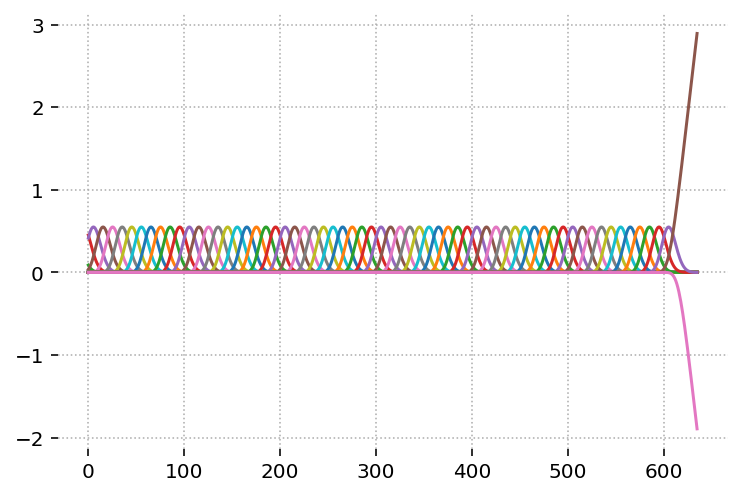

In [57]:
for i in range(B0.shape[-1]):
    plt.plot(B0[0,:,i])

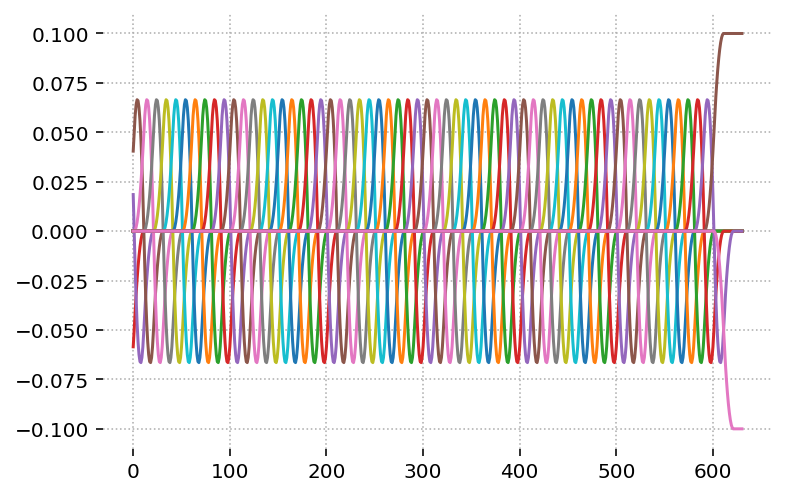

In [58]:
for i in range(B0.shape[-1]):
    plt.plot(B0[1,:-5,i])

In [59]:
np.sum(np.diff(B0[1,-30:,-1])+1 == 1)

10

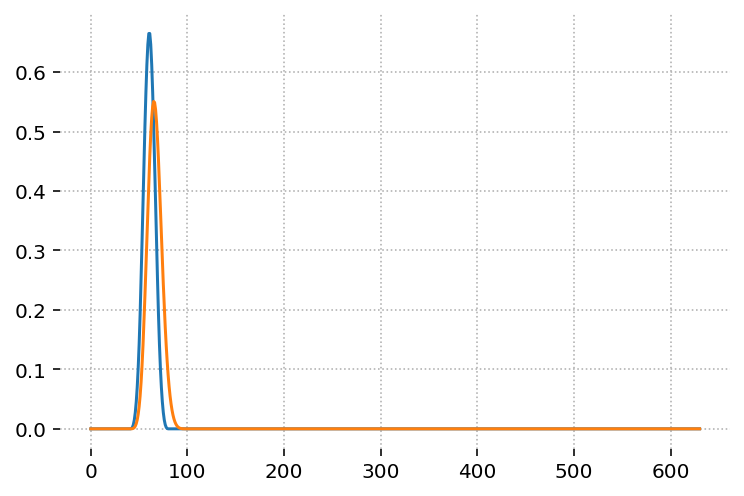

In [60]:
plt.plot(B0[1,:-5,10].cumsum())
plt.plot(B0[0,:-5,10])


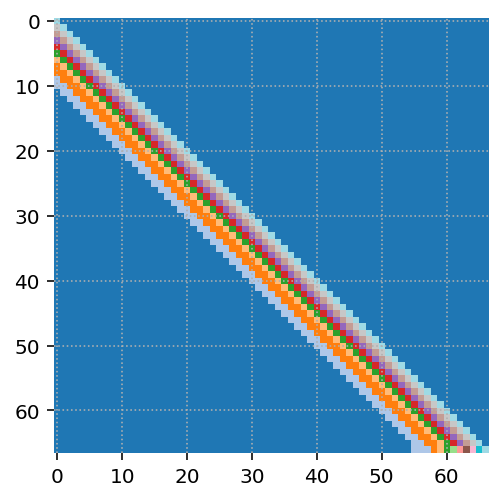

In [61]:
arma2 = np.eye(B0.shape[-1]) ## Prior covariance matrix for the splines to avoid too many wrinkles
for j in range(arma2.shape[0]-1):
    arma2[j+1,j] = -0.75
arma2[-1,-2] = -.9
arma2 = np.linalg.inv(arma2)
plt.imshow(arma2)

### Case and genome data
Prepare as arrays and add Germany as a whole

In [62]:
seq_index = np.array([list(cases_land.columns).index(i) for i in genomes.index.levels[1]])

In [63]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates, alias

In [64]:
from numpyro.infer import Trace_ELBO

In [65]:
GG = np.concatenate([G, G.sum(0, keepdims=True)], axis=0) # Add Germany as a whole
CC = np.concatenate([C, C.sum(0, keepdims=True)], axis=0)    

In [66]:
CC[2,cases_land.columns == np.datetime64("2022-03-08")] = np.nan # int women's day in Berlin..
#GG[-1, genomes.index.levels[1] <= "2022-07-15", merged_lineages_alias.index("BA.2.75")] = 0
GG[:, genomes.index.levels[1] < "2022-02-01", merged_lineages_alias.index("BA.5")] = 0 # Some erroneous BA.5
GG[:, genomes.index.levels[1] >= "2021-11-01", merged_lineages_alias.index("B")] = 0 # Issues with spurious B lineages later on
GG[:, genomes.index.levels[1] >= "2021-11-01", merged_lineages_alias.index("B.1.1.7")] = 0 # Issues with spurious B lineages later on
GG[:, genomes.index.levels[1] >= "2021-11-01", merged_lineages_alias.index("B.1.351")] = 0 # Issues with spurious B lineages later on
GG[:, (genomes.index.levels[1] < "2021-11-01").reshape(-1,1) * np.array([x.startswith("B.1.1.529") for x in merged_lineages]).reshape(1,-1)] = 0
GG[:, (genomes.index.levels[1] < "2021-04-01").reshape(-1,1) * np.array([x.startswith("B.1.617.2") for x in merged_lineages]).reshape(1,-1)] = 0

In [67]:
GG[:, genomes.index.levels[1] <= "2021-04-01"][:,:,[x.startswith("B.1.617.2") for x in merged_lineages]].sum()

0.0

In [68]:
x = (GG[-1].cumsum(0)>0).argmax(0)
dict(zip(merged_lineages, x))

{'A': 5,
 'B.1.1.7': 1,
 'B.1.1.28.1': 33,
 'B.1.1.318': 20,
 'B.1.1.529': 348,
 'B.1.1.529.1': 326,
 'B.1.1.529.1.1': 320,
 'B.1.1.529.2': 336,
 'B.1.1.529.2.12.1': 458,
 'B.1.1.529.2.75': 518,
 'B.1.1.529.2.75.1': 541,
 'B.1.1.529.2.75.2': 579,
 'B.1.1.529.4': 415,
 'B.1.1.529.4.6': 489,
 'B.1.1.529.5': 429,
 'B.1.1.529.5.2': 419,
 'B.1.1.529.5.2.1.7': 528,
 'B.1.1.529.5.2.1.11': 543,
 'B.1.1.529.5.2.1.13': 572,
 'B.1.1.529.5.2.1.14': 553,
 'B.1.351': 4,
 'B.1.525': 17,
 'B.1.617.2': 94,
 'B.1.617.2.4.2': 186,
 'B.1.617.2.36.1': 276,
 'B.1.617.2.43': 170,
 'B.1.617.2.46.6': 189,
 'B.1.621': 98,
 'B': 0}

### Model
Multi-lineage model with variable growth rates (random effect) across states

In [69]:
model = MultiLineageTimeShift(
    CC[[-1]],
    GG[[-1]],    
    seq_index,
    np.concatenate([capita.values, capita.values.sum().reshape(1)])[[-1]],
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    #b_scale=0.01,
    b0_scale=0.3,
    #c_scale=30,
    c0_scale=5,
    c0_loc=-10,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.001,#.001,
    alpha1=1000., 
    week=True,
    fit_logits=False,#True,
    ancestor_matrix=A,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':10000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=100), 'num_epochs':2000, 'lr':0.03, 'lrd': 0.5 ** (1/2000), 'num_samples': 100, 'log_freq':200}

)

In [70]:
model.fit(num_epochs=200)

SVI step 0 / 200 | 0 %


(0.0, 1000000.0)

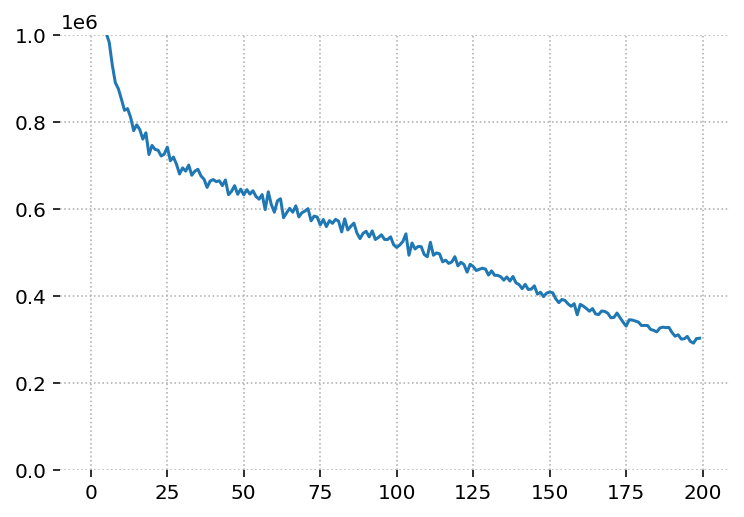

In [71]:
plt.plot(model.loss)
plt.ylim((0,1e6))

In [72]:
model.fit(num_epochs=400)

SVI step 0 / 400 | 0 %
SVI step 200 / 400 | 50 %


Text(0, 0.5, 'ELBO')

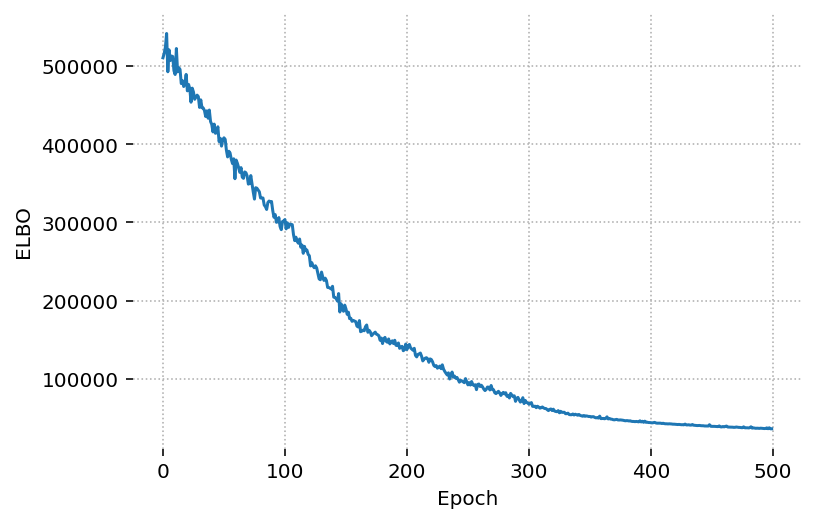

In [73]:
plt.plot(model.loss[100:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [74]:
model.fit(num_epochs=2000)

SVI step 0 / 2,000 | 0 %
SVI step 200 / 2,000 | 10 %
SVI step 400 / 2,000 | 20 %
SVI step 600 / 2,000 | 30 %
SVI step 800 / 2,000 | 40 %
SVI step 1,000 / 2,000 | 50 %
SVI step 1,200 / 2,000 | 60 %
SVI step 1,400 / 2,000 | 70 %
SVI step 1,600 / 2,000 | 80 %
SVI step 1,800 / 2,000 | 90 %


Text(0, 0.5, 'ELBO')

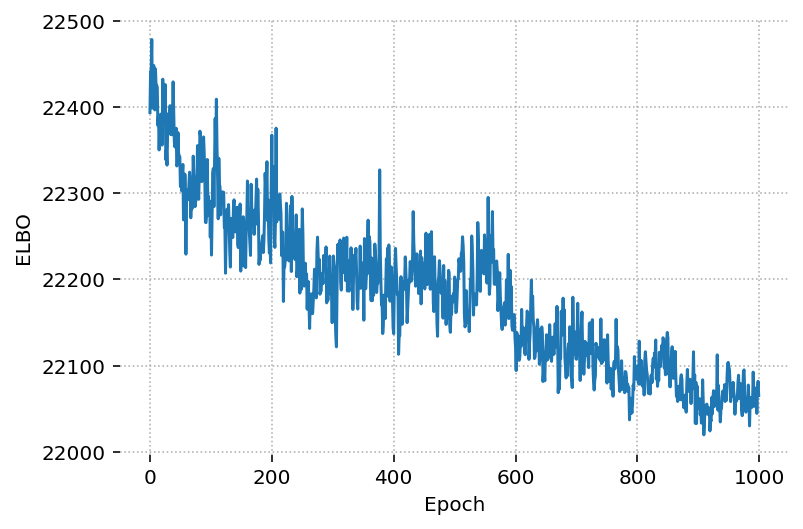

In [75]:
plt.plot(model.loss[-1000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')
#plt.ylim((model.loss[2000],model.loss[1200]))

In [76]:
lineage_colors = {'B.1.1.529':'C7',
                 'BA.1': 'rebeccapurple',#'mistyrose', #
                 'BA.1.1': 'C4',#"lavender", #
                 'BA.2':"C1", 
                 'BA.2.12.1':"C6",
                 'BA.2.75':"orangered",
                  'BA.2.75.1':"salmon",
                  'BA.2.75.2':"C3",
                 'BA.4':"C8",
                 'BA.4.6': 'peru',
                 'BA.5':"C9",
                  'BA.5.2': 'darkcyan',
                  "BF.7":"limegreen",
                  'BF.11':"C2",
                  'BF.13':"yellowgreen",
                  'BF.14':'green',
                 #'Other':"C7",
                 'B.1.617.2': 'C0',
                 'AY.4.2': 'lightblue',
                  'AY.36.1': 'steelblue',
                  'AY.43': 'skyblue',
                  'AY.46.6': 'lightsteelblue',
                  'A': 'lightgrey',
                  'B': 'lightgrey',
                  'B.1.1.7': 'navy' ,
                  'B.1.351': 'black',
                  'P.1' : 'slategrey',
                  'B.1.525':'C7',
                  'B.1.1.318': 'grey',
                  'B.1.621':'grey'
                 } #"aliceblue"}

In [77]:
merged_lineages_alias

['A',
 'B.1.1.7',
 'P.1',
 'B.1.1.318',
 'B.1.1.529',
 'BA.1',
 'BA.1.1',
 'BA.2',
 'BA.2.12.1',
 'BA.2.75',
 'BA.2.75.1',
 'BA.2.75.2',
 'BA.4',
 'BA.4.6',
 'BA.5',
 'BA.5.2',
 'BF.7',
 'BF.11',
 'BF.13',
 'BF.14',
 'B.1.351',
 'B.1.525',
 'B.1.617.2',
 'AY.4.2',
 'AY.36.1',
 'AY.43',
 'AY.46.6',
 'B.1.621',
 'B']

In [78]:
merged_lineages_alias = [alias(x) for x in merged_lineages]

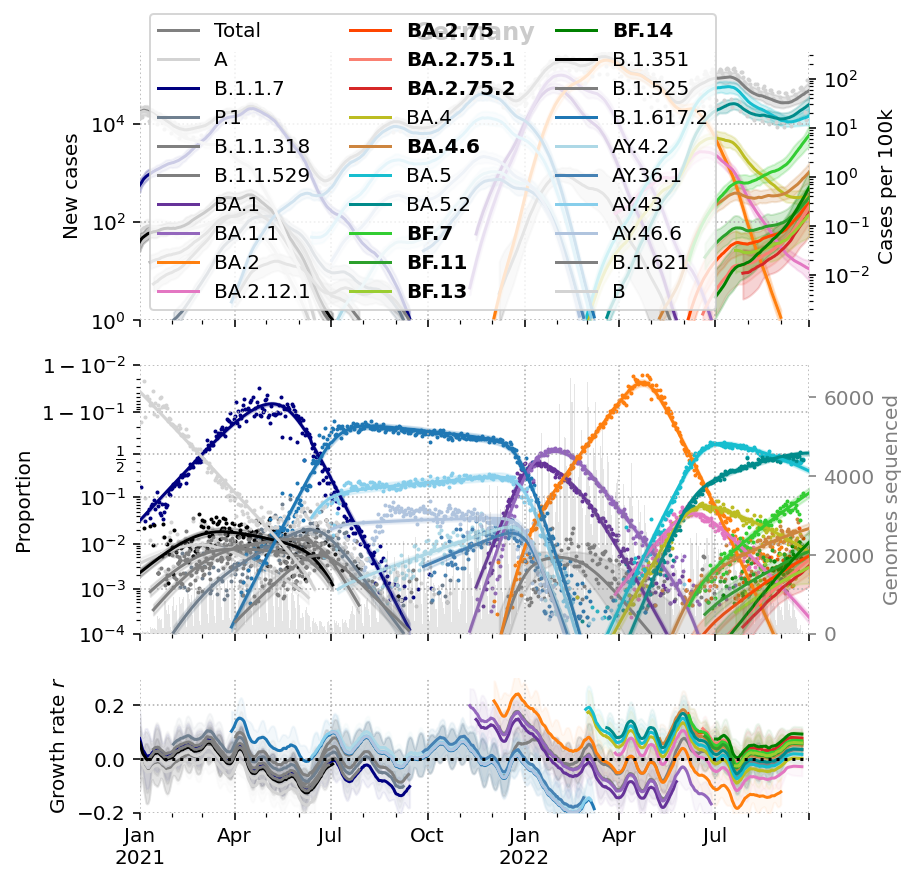

In [79]:
#from genomicsurveillance.plots.england import plot_lad, 
plt.rcParams['font.sans-serif'] = ["DejaVu Sans"]
from matplotlib import gridspec
from genomicsurveillance.plots.england import plot_median_and_ci
#from matplotlib import rc
#rc('text', usetex=False)
for i,r in [(-1, "Germany")]:#enumerate(cases_land.index.to_list() + ["Germany"]):
    w = np.where(GG[i].sum(0) >= 3)[0]
    #w = list(set(w) - set([0,GG.shape[2]-2]))
    #w = [w[-1]] + w[:-1]
    #plt.set_cmap("tab20")
    col = [lineage_colors[x] for x in merged_lineages_alias]
    plot_lad(model, i, CC, GG, seq_index, start_date=start_date, show_start_date=start_date,
        lin = w,
        labels = np.array(merged_lineages_alias)[w], #[x if not x in ["BA.2.75", "BA.4.6","BA.5.2.1.7","BA.5.2.1.11"] else r"$\bf{"+x+"}$" for x in merged_lineages_alias])[w],#genomes.columns[w],
        #lin_colors=np.array(5*['C7','C3',"C4","C1", "C6","C8" ,"C9", "C7","C0"])[w],#, "C6", "C1","C8"],
        lin_colors=np.array(5*col)[w],#, "C6", "C1","C8"],
        #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
        case_color="grey",
        case_markercolor="lightgrey",
             lin_marker=".",
             lin_marker_size=2,
            figsize=(8,6),
            prop_err=False,
            show_Rt=False)

    ax=plt.gcf().get_axes()
    
    ax[0].set_title(r, size=12, weight='bold')
    ax[0].set_yscale('log')
    ax[0].set_ylim((1,None))
   
    #ax[1].grid(which='both', ls=":")
    #ax[0].legend(loc='center left')
    #ax[2].set_ylim((-0.2,0.3))
    #ax[3].grid(False)
    
    #for a in ax:
        #a.xaxis.set_major_formatter(pd.plotting._matplotlib.converter.TimeSeries_DateFormatter("D"))
        #for s in a.spines:
        #    a.spines[s].set_visible(True)
    #fig = plt.gcf()
    #plt.tight_layout()
    ax[0].set_ylim((None, np.nanmax(CC[i,:])))
    ax[1].set_yscale("logit")
    ax[1].set_ylim((1e-4,1-1e-2))
    ax[2].set_ylim((-.2,.3))
    ax[1].get_legend().remove()
    ax[2].get_legend().remove()
    for i in range(3):
        ax[i].set_position(gridspec.GridSpec(3, 1, height_ratios=[1,1, 0.5])[i].get_position(plt.gcf()))
    #ax[2].legend(loc="upper left")
    ax[2].axhline(0, color='k', ls=":")
    leg = ax[0].legend(loc="lower left", ncol=3)
    for l in leg.get_texts():
        if re.match("|".join(["BA.2.75", "BA.4.6","BF"]),l.get_text()):
            l.set_weight('bold')
    plt.gcf().set_size_inches(6,7)

b = np.array(model.posterior['b1'])
b[b==0] = np.nan
b[...,-1]= 0
r = pd.DataFrame((b - b[...,[1]]).mean((0,2)), columns=merged_lineages_alias, index=["Germany"])# cases_land.index.to_list() + ["Germany"])

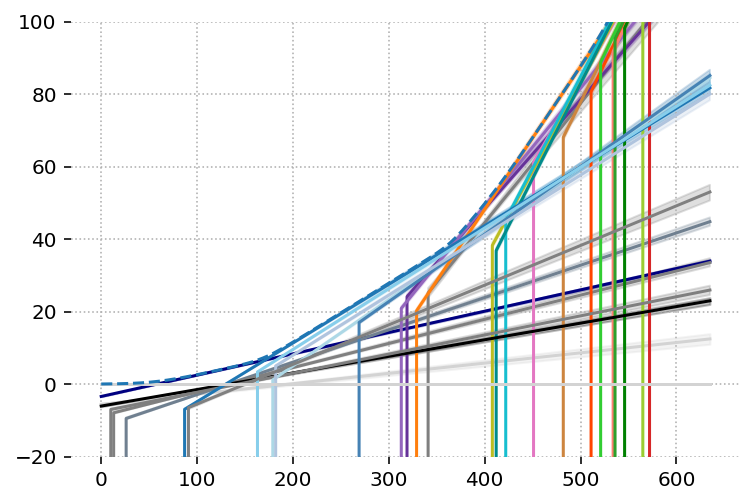

In [80]:
l = model.get_logits(ltla=-1).squeeze()
#l -= logsumexp(l.mean(0),-1)[...,np.newaxis]
#m = 0.5 * (((r-r[0])/x)[:-1].mean()) * np.arange(l.shape[1])**2 + r[1]*np.arange(l.shape[1]) - 15#np.max(np.mean(l,0),-1)
for i in range(l.shape[-1]):
    plt.plot(np.median(l[...,i],0), c=lineage_colors[merged_lineages_alias[i]])
    plt.fill_between(x=np.arange(l.shape[1]), y1=np.quantile(l[...,i],0.05, 0), y2=np.quantile(l[...,i],0.95, 0), color=lineage_colors[merged_lineages_alias[i]], alpha=0.25)
plt.ylim((-20,100))
#l.shape
#plt.plot(seq_index, 0.5 * 0.0008 * seq_index**2)

from scipy.special import logsumexp
plt.plot(logsumexp(l.mean(0).squeeze(), -1), ls="--")


#plt.plot(np.max(np.mean(l,0),-1))

In [81]:
r

,A,B.1.1.7,P.1,B.1.1.318,B.1.1.529,BA.1,BA.1.1,BA.2,BA.2.12.1,BA.2.75,...,BF.14,B.1.351,B.1.525,B.1.617.2,AY.4.2,AY.36.1,AY.43,AY.46.6,B.1.621,B
Germany,-0.030336,0.0,0.030266,0.007779,0.270605,0.241364,0.266129,0.335187,0.40141,0.492942,...,0.519741,-0.013186,-0.006395,0.103052,0.12386,0.127152,0.10857,0.106464,0.050511,-0.058861


(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(1, 0, 'A'),
  Text(2, 0, 'B.1.1.7'),
  Text(3, 0, 'P.1'),
  Text(4, 0, 'B.1.1.318'),
  Text(5, 0, 'B.1.1.529'),
  Text(6, 0, 'BA.1'),
  Text(7, 0, 'BA.1.1'),
  Text(8, 0, 'BA.2'),
  Text(9, 0, 'BA.2.12.1'),
  Text(10, 0, 'BA.2.75'),
  Text(11, 0, 'BA.2.75.1'),
  Text(12, 0, 'BA.2.75.2'),
  Text(13, 0, 'BA.4'),
  Text(14, 0, 'BA.4.6'),
  Text(15, 0, 'BA.5'),
  Text(16, 0, 'BA.5.2'),
  Text(17, 0, 'BF.7'),
  Text(18, 0, 'BF.11'),
  Text(19, 0, 'BF.13'),
  Text(20, 0, 'BF.14'),
  Text(21, 0, 'B.1.351'),
  Text(22, 0, 'B.1.525'),
  Text(23, 0, 'B.1.617.2'),
  Text(24, 0, 'AY.4.2'),
  Text(25, 0, 'AY.36.1'),
  Text(26, 0, 'AY.43'),
  Text(27, 0, 'AY.46.6'),
  Text(28, 0, 'B.1.621'),
  Text(29, 0, 'B')])

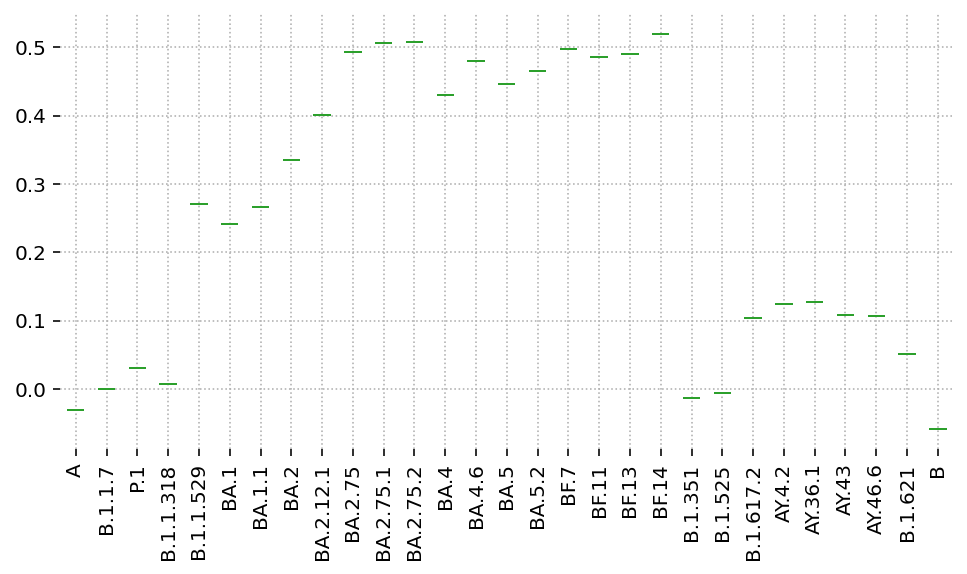

In [82]:
#r[r==0] = np.nan
plt.figure(figsize=(8,4))
r.boxplot(figsize=(8,4))
plt.xticks(rotation=90)
#r.mean(0).plot(ls="", marker=".")


In [83]:
import re

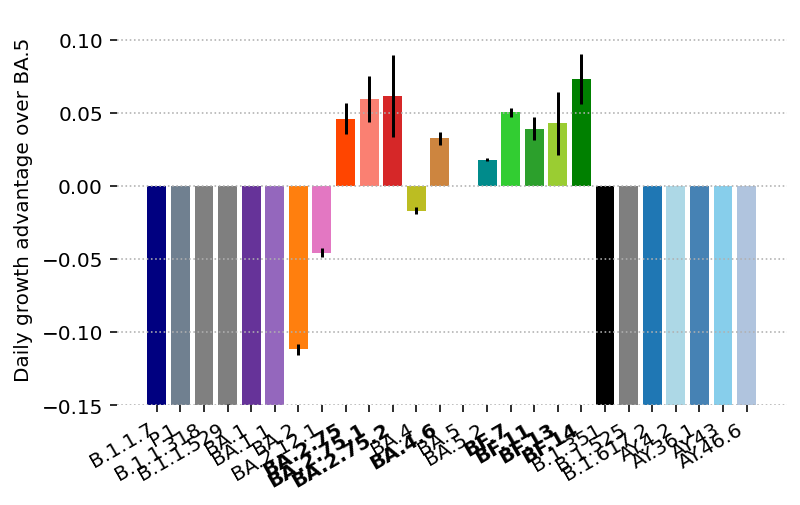

[Text(0, 0, 'B.1.1.7'), Text(1, 0, 'P.1'), Text(2, 0, 'B.1.1.318'), Text(3, 0, 'B.1.1.529'), Text(4, 0, 'BA.1'), Text(5, 0, 'BA.1.1'), Text(6, 0, 'BA.2'), Text(7, 0, 'BA.2.12.1'), Text(8, 0, 'BA.2.75'), Text(9, 0, 'BA.2.75.1'), Text(10, 0, 'BA.2.75.2'), Text(11, 0, 'BA.4'), Text(12, 0, 'BA.4.6'), Text(13, 0, 'BA.5'), Text(14, 0, 'BA.5.2'), Text(15, 0, 'BF.7'), Text(16, 0, 'BF.11'), Text(17, 0, 'BF.13'), Text(18, 0, 'BF.14'), Text(19, 0, 'B.1.351'), Text(20, 0, 'B.1.525'), Text(21, 0, 'B.1.617.2'), Text(22, 0, 'AY.4.2'), Text(23, 0, 'AY.36.1'), Text(24, 0, 'AY.43'), Text(25, 0, 'AY.46.6')]


In [84]:
baseline = "BA.5"
s = pd.DataFrame((b - b[...,[merged_lineages_alias.index(baseline)]]).mean((2))[:,-1], columns=merged_lineages_alias).iloc[:,1:-2]
#s.boxplot()
plt.figure(figsize=(6,4))
plt.bar(s.columns, s.iloc[:-1,:].mean(), yerr=2*s.std(), color=[lineage_colors[x] for x in s.columns])
#plt.ylim((-0.15,0.2))
plt.ylim((-0.15,None))
#plt.draw()
#lt.xticks(rotation=45)
plt.ylabel(f"Daily growth advantage over {baseline}")
plt.grid(False)
plt.grid(axis="y")
plt.gcf().autofmt_xdate()
plt.draw()
xl = plt.gca().get_xticklabels()
for l in xl:
    if re.match("|".join(["BA.2.75", "BA.4.6","BF"]),l.get_text()):
        l.set_weight('bold')
plt.show()
print(xl)

In [85]:
q=(0.025,0.5,0.975)
pd.DataFrame(np.quantile(model.get_probabilities()[:,0,-1:,:], q, 0).squeeze(), index=np.array(q), columns=merged_lineages_alias)

,A,B.1.1.7,P.1,B.1.1.318,B.1.1.529,BA.1,BA.1.1,BA.2,BA.2.12.1,BA.2.75,...,BF.14,B.1.351,B.1.525,B.1.617.2,AY.4.2,AY.36.1,AY.43,AY.46.6,B.1.621,B
0.025,0.0,0.0,0.0,0.0,1.752423e-17,2.792730e-16,1.780493e-13,9.523820e-07,0.000169,0.002939,...,0.005650,0.0,0.0,1.330174e-32,1.851459e-31,2.903002e-31,2.499139e-32,1.760829e-33,1.401298e-45,0.0
0.500,0.0,0.0,0.0,0.0,8.825135e-15,4.683868e-16,3.292137e-13,1.389242e-06,0.000228,0.005375,...,0.010840,0.0,0.0,3.020790e-32,4.546849e-31,7.911301e-31,5.905200e-32,4.718432e-33,9.108440e-45,0.0
0.975,0.0,0.0,0.0,0.0,6.576061e-12,7.736244e-16,5.481857e-13,2.114588e-06,0.000276,0.008367,...,0.019593,0.0,0.0,8.602334e-32,1.380215e-30,2.904678e-30,1.480215e-31,1.381844e-32,1.201613e-43,0.0


In [86]:
model.posterior['b1'].mean(0)[-1,0,:]

array([0.0285254 , 0.05886148, 0.08912728, 0.06664069, 0.32946622,
       0.3002259 , 0.32499093, 0.39404833, 0.46027127, 0.5518035 ,
       0.565265  , 0.56678176, 0.48898536, 0.5383428 , 0.5057511 ,
       0.5238038 , 0.55610234, 0.54504335, 0.54862183, 0.5786026 ,
       0.04567507, 0.05246626, 0.16191332, 0.18272139, 0.18601388,
       0.16743127, 0.16532563, 0.10937264, 0.        ], dtype=float32)

In [87]:
f = model.params['bc0_loc'].reshape(2,-1)[0,:]/100
f = np.append(f, -A[-1,:-1] @ f / A[-1,-1])
A @ f

array([0.02850389, 0.05883592, 0.08916283, 0.0666543 , 0.32893792,
       0.30002529, 0.32474664, 0.39385766, 0.4600615 , 0.55214773,
       0.56504238, 0.56507193, 0.48886611, 0.53812307, 0.50569376,
       0.52376442, 0.55610297, 0.54500991, 0.54804634, 0.57740853,
       0.045631  , 0.05254029, 0.16176689, 0.182615  , 0.18603808,
       0.16727273, 0.16520832, 0.10904925, 0.        ])

In [88]:
pd.Series(np.diff(model.get_logits().mean(0)[-1,-2:,:], axis=0)[0], index=merged_lineages)

A                     0.028525
B.1.1.7               0.058861
B.1.1.28.1            0.089119
B.1.1.318             0.066639
B.1.1.529             0.329460
B.1.1.529.1           0.300217
B.1.1.529.1.1         0.324982
B.1.1.529.2           0.394058
B.1.1.529.2.12.1      0.460251
B.1.1.529.2.75        0.551804
B.1.1.529.2.75.1      0.565262
B.1.1.529.2.75.2      0.566788
B.1.1.529.4           0.488983
B.1.1.529.4.6         0.538330
B.1.1.529.5           0.505753
B.1.1.529.5.2         0.523819
B.1.1.529.5.2.1.7     0.556122
B.1.1.529.5.2.1.11    0.545029
B.1.1.529.5.2.1.13    0.548615
B.1.1.529.5.2.1.14    0.578613
B.1.351               0.045677
B.1.525               0.052467
B.1.617.2             0.161911
B.1.617.2.4.2         0.182724
B.1.617.2.36.1        0.186012
B.1.617.2.43          0.167419
B.1.617.2.46.6        0.165321
B.1.621               0.109375
B                     0.000000
dtype: float32

In [89]:
w=np.append(model.params['day_mu'][2], 0)
np.exp(w-np.log(np.sum(np.exp(w ), keepdims=True))).sum()

1.0000000000000002

In [90]:
model.posterior.keys()

dict_keys(['b1', 'bc0', 'beta1', 'c1', 't', 'b0'])

In [91]:
λ = np.median(model.get_lambda_lineage(),0) / model.population[:,np.newaxis, np.newaxis]

In [92]:
λ.shape

(1, 636, 29)

In [93]:
λ[-1,-1]/λ[-1,-1].sum()

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       8.85383230e-15, 4.83656654e-16, 3.25954552e-13, 1.38460549e-06,
       2.30013056e-04, 5.06582157e-03, 4.34633364e-03, 3.20187756e-03,
       6.61725575e-03, 2.16338599e-02, 3.02429382e-01, 5.14272083e-01,
       1.22142623e-01, 6.67647654e-03, 2.89283127e-03, 1.04900577e-02,
       0.00000000e+00, 0.00000000e+00, 2.96354573e-32, 4.47711826e-31,
       7.99151756e-31, 5.66985890e-32, 4.80876165e-33, 8.74827717e-45,
       0.00000000e+00])

In [94]:
merged_lineages_alias

['A',
 'B.1.1.7',
 'P.1',
 'B.1.1.318',
 'B.1.1.529',
 'BA.1',
 'BA.1.1',
 'BA.2',
 'BA.2.12.1',
 'BA.2.75',
 'BA.2.75.1',
 'BA.2.75.2',
 'BA.4',
 'BA.4.6',
 'BA.5',
 'BA.5.2',
 'BF.7',
 'BF.11',
 'BF.13',
 'BF.14',
 'B.1.351',
 'B.1.525',
 'B.1.617.2',
 'AY.4.2',
 'AY.36.1',
 'AY.43',
 'AY.46.6',
 'B.1.621',
 'B']

In [95]:
λ[-1,-1] / λ[-1,-1].sum()

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       8.85383230e-15, 4.83656654e-16, 3.25954552e-13, 1.38460549e-06,
       2.30013056e-04, 5.06582157e-03, 4.34633364e-03, 3.20187756e-03,
       6.61725575e-03, 2.16338599e-02, 3.02429382e-01, 5.14272083e-01,
       1.22142623e-01, 6.67647654e-03, 2.89283127e-03, 1.04900577e-02,
       0.00000000e+00, 0.00000000e+00, 2.96354573e-32, 4.47711826e-31,
       7.99151756e-31, 5.66985890e-32, 4.80876165e-33, 8.74827717e-45,
       0.00000000e+00])

In [96]:
from genomicsurveillance.misc import get_transmissibility

In [97]:
GG.shape

(17, 629, 29)

In [98]:
d = model.posterior['bc0'].mean(0).squeeze()[:GG.shape[-1]-1]

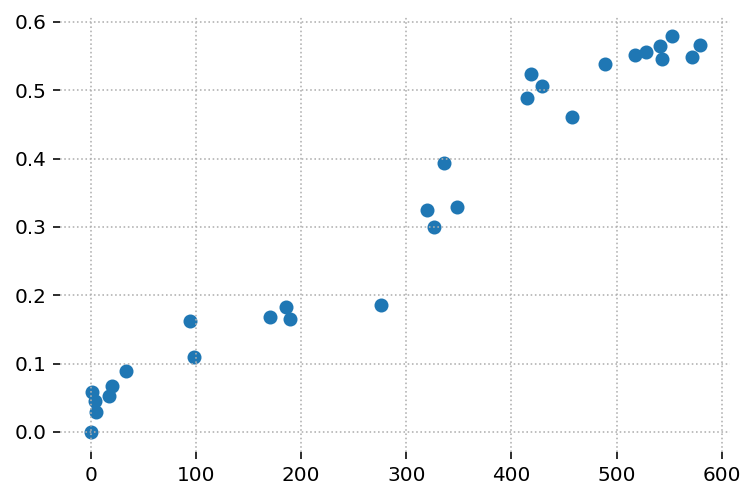

In [99]:
x = (GG[-1].cumsum(0)>0).argmax(0)
r = b.squeeze().mean(0)
plt.scatter(x, r)

In [100]:
x = (GG[-1].cumsum(0)>0).argmax(0)
y = (-GG[-1]).cumsum(0).argmin(0)
dict(zip(merged_lineages_alias, genomes.index.levels[1][y]))

{'A': Timestamp('2021-06-21 00:00:00'),
 'B.1.1.7': Timestamp('2021-10-04 00:00:00'),
 'P.1': Timestamp('2021-10-22 00:00:00'),
 'B.1.1.318': Timestamp('2022-03-24 00:00:00'),
 'B.1.1.529': Timestamp('2022-06-30 00:00:00'),
 'BA.1': Timestamp('2022-09-09 00:00:00'),
 'BA.1.1': Timestamp('2022-07-21 00:00:00'),
 'BA.2': Timestamp('2022-09-20 00:00:00'),
 'BA.2.12.1': Timestamp('2022-09-06 00:00:00'),
 'BA.2.75': Timestamp('2022-09-22 00:00:00'),
 'BA.2.75.1': Timestamp('2022-09-18 00:00:00'),
 'BA.2.75.2': Timestamp('2022-09-20 00:00:00'),
 'BA.4': Timestamp('2022-09-20 00:00:00'),
 'BA.4.6': Timestamp('2022-09-20 00:00:00'),
 'BA.5': Timestamp('2022-09-22 00:00:00'),
 'BA.5.2': Timestamp('2022-09-22 00:00:00'),
 'BF.7': Timestamp('2022-09-22 00:00:00'),
 'BF.11': Timestamp('2022-09-20 00:00:00'),
 'BF.13': Timestamp('2022-09-14 00:00:00'),
 'BF.14': Timestamp('2022-09-20 00:00:00'),
 'B.1.351': Timestamp('2021-09-06 00:00:00'),
 'B.1.525': Timestamp('2021-07-02 00:00:00'),
 'B.1.617.2'

In [101]:
f = np.einsum("...l,...l", model.get_probabilities(), b).squeeze()

In [102]:
r = b.squeeze()
from adjustText import adjust_text

In [103]:
r.shape

(100, 29)

In [104]:
f.shape

(100, 636)

In [105]:
r.shape

(100, 29)

24

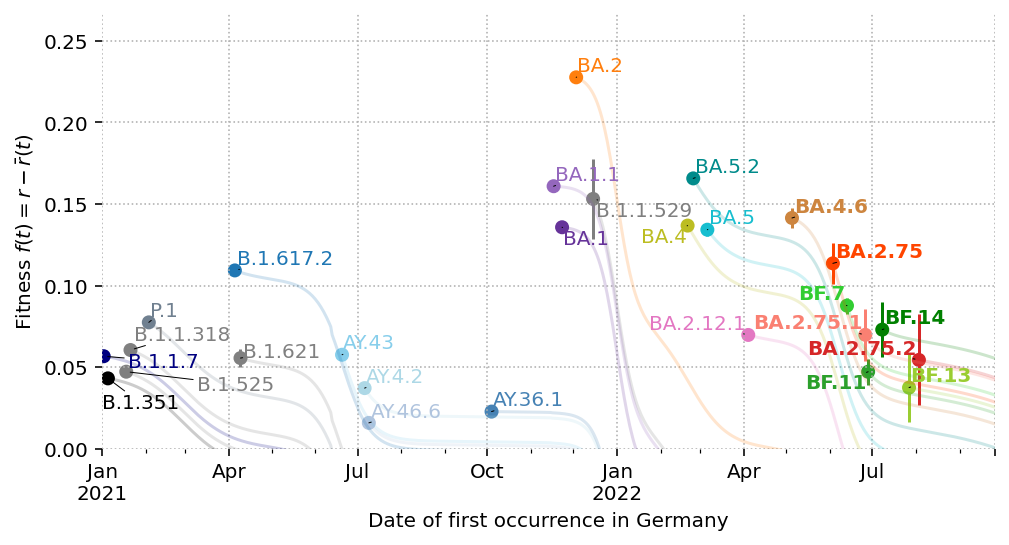

In [106]:
x = (GG[-1].cumsum(0)>0).argmax(0)
pd.Series(np.nan, index=cases_land.columns).plot()
df = pd.DataFrame({"Growth advantage to Delta":r.mean(), "Relative growth advantage f":(r-f[:,x]).mean(0), "Lineage":merged_lineages_alias},index=cases_land.columns[x]).iloc[1:-1,:]
df["Relative growth advantage f"].plot(ls="", figsize=(8,4))
plt.errorbar(df.index, df["Relative growth advantage f"], yerr=2*(r-f[:,x]).std(0)[1:-1], ls="", c=[lineage_colors[x] for x in df.Lineage])
plt.scatter(df.index, df["Relative growth advantage f"], marker='o', c=[lineage_colors[x] for x in df.Lineage])
for i in range(df.shape[0]):
    j = merged_lineages_alias.index(df.Lineage[i])
    plt.plot(cases_land.columns[x[j]] + np.arange(f.shape[1]-x[j]).astype("timedelta64[D]"), (r[:,[j]]-f[:,x[j]:]).mean(0), c=lineage_colors[df.Lineage[i]], ls="-", alpha=0.2)
text=[]
for x,y,s in zip(df.index.tolist(), df["Relative growth advantage f"],df.Lineage.tolist()):
    text.append(plt.text(x,y,s, ha='left', va='center', color=lineage_colors[s]))
plt.xlabel("Date of first occurrence in Germany")
#plt.xlabel('')
plt.ylabel("Fitness $f(t) = r-\\bar{r}(t)$")
for l in text:
    if re.match("|".join(["BA.2.75", "BA.4.6","BF"]),l.get_text()):
        l.set_weight('bold')
plt.ylim((0.00,None))
#secax = plt.gca().secondary_yaxis('right', functions=(lambda x: np.log(2)/x, lambda x: 1/np.log(2)/x))
#secax.set_ylabel('Doubling time')
#secax.set_yscale('log')
#secax.set_yticks(np.concatenate([np.arange(50,10,-10),np.arange(10,1,-1)]))
#secax.spines['right'].set_visible(False)
adjust_text(text, 
                #add_objects=line, 
                #expand_objects = (1,1),
                #force_objects =  (0, 0.2),
                #only_move=dict(objects='y', text='y', points='y'),
                arrowprops=dict(arrowstyle="-", color='k', lw=0.5), )

In [107]:
np.mean(model.posterior['c1'].squeeze(),0)

array([ -5.6411085,  -3.7525115,  -9.625613 ,  -7.99009  ,  -9.37358  ,
        -6.696161 ,  -8.972798 , -12.241489 ,  -5.017369 ,  -9.142902 ,
        -7.062373 ,  -1.32993  , -12.071831 , -10.260397 ,  -9.89735  ,
       -14.89351  ,  -4.9145403,  -4.279432 ,  -1.1632204,  -5.304563 ,
        -6.1929035,  -7.0441146,  -8.877759 ,  -7.265328 ,  -5.686384 ,
        -3.2730095,  -3.8278806,  -8.632096 ,   0.       ], dtype=float32)

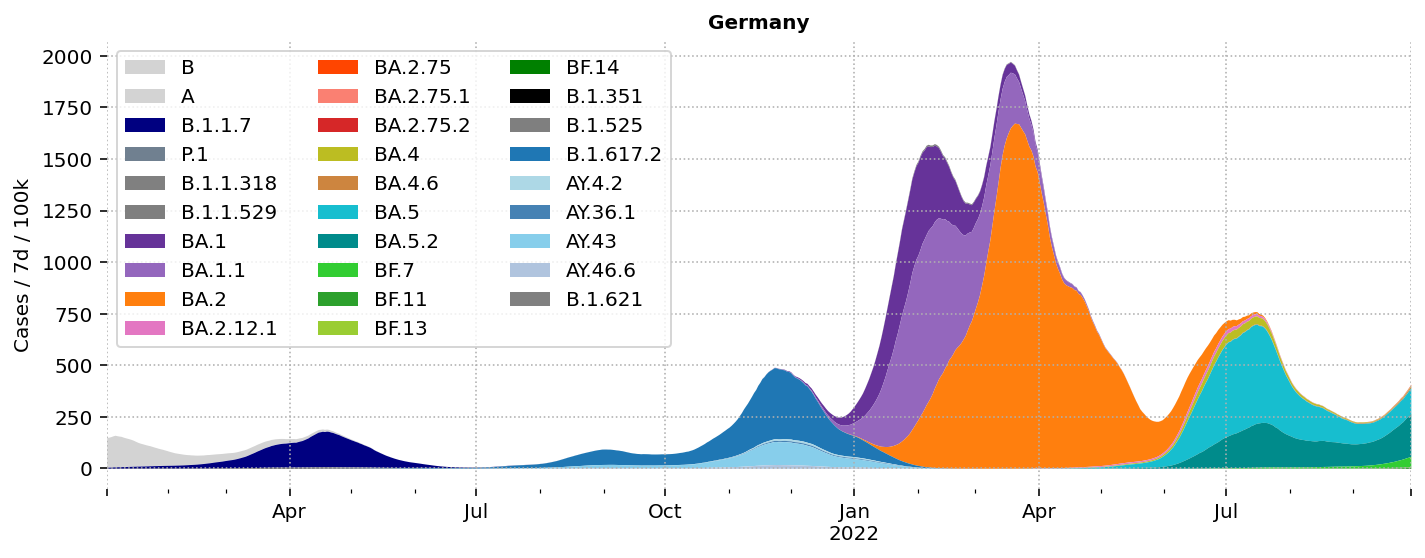

In [108]:
fig, ax = plt.subplots(1,1, figsize=(10,4), sharex=True, sharey=True)
ax = [ax]
#ax = ax.flatten()
#col = ['C7','C3',"C4","C1", "C6","C5","C8" ,"C9", "C7","C0"]
#labels =[alias(x) for x in merged_lineages]
col = lineage_colors #dict(zip(labels, col))
for i,r in enumerate(["Germany"]):
    y = pd.DataFrame(λ[i,:,:], columns=merged_lineages_alias, index=cases_land.columns[1] + np.arange(λ.shape[1]).astype('timedelta64[D]')) #cases_land.loc[r].loc["2021-12-01":,'AnzahlFall'] / capita[r] * 1000 #* 700
    #y = y.drop(columns=["B.1.1.529","Other"])
    y = y.iloc[:,[i-1  for i in range(y.shape[1])]].iloc[:,::-1].cumsum(1)* 1000 * 700
    #y.index.name = 'date'
    #x = prop_bl.loc[r,:,:][0].unstack()
    #z = x[0.5] * y
    y["BA.1"].plot(ax=ax[i], ls="", label="")
    #(cases_land.loc[r]/capita[r]*1000 * 700).plot(ax=ax[i], marker=".", markersize=1.3, color="k", ls="", label="")
    for j in range(y.shape[1]-1,-1,-1):
        ax[i].fill_between(y.index, y.iloc[:,j-1] if j > 0 else 0, y.iloc[:,j], color=col[y.columns[j]], alpha=1, lw=0, label=y.columns[j])
    #ax[i].fill_between(y.index, y["BA.2"], y["BA.1"], color='C3', alpha=1, lw=0, label="BA.1")
    #ax[i].fill_between(y.index, y["B.1.617.2"], y["BA.2"], color='C1', alpha=1, lw=0, label="BA.2")
    #ax[i].fill_between(y.index, y["B.1.617.2"], color='C0', alpha=.5, lw=0, label="B.1.617.2")
    #ax[i].fill_between(z.index, y-x[0.95]*y, y-x[0.5]*y, color='none',alpha=1, lw=0, label="Omicron", hatch="//////", edgecolor="C3")
    ax[i].set_title(r, size=10 , weight='bold')
    ax[i].set_xlabel(None)
    ax[i].set_ylabel("Cases / 7d / 100k")
    ax[i].grid(ls=":")
    #ax[i].set_xlim(("2021-12-01",None))
    #ax[i].set_yscale("log")
    #ax[i].set_ylim((0,100))

    for a in ax[i].spines.values():
        a.set_visible(False)
ax[-1].legend(title=None, ncol=3)
plt.tight_layout()
#fig.savefig("plots/omi_abs_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

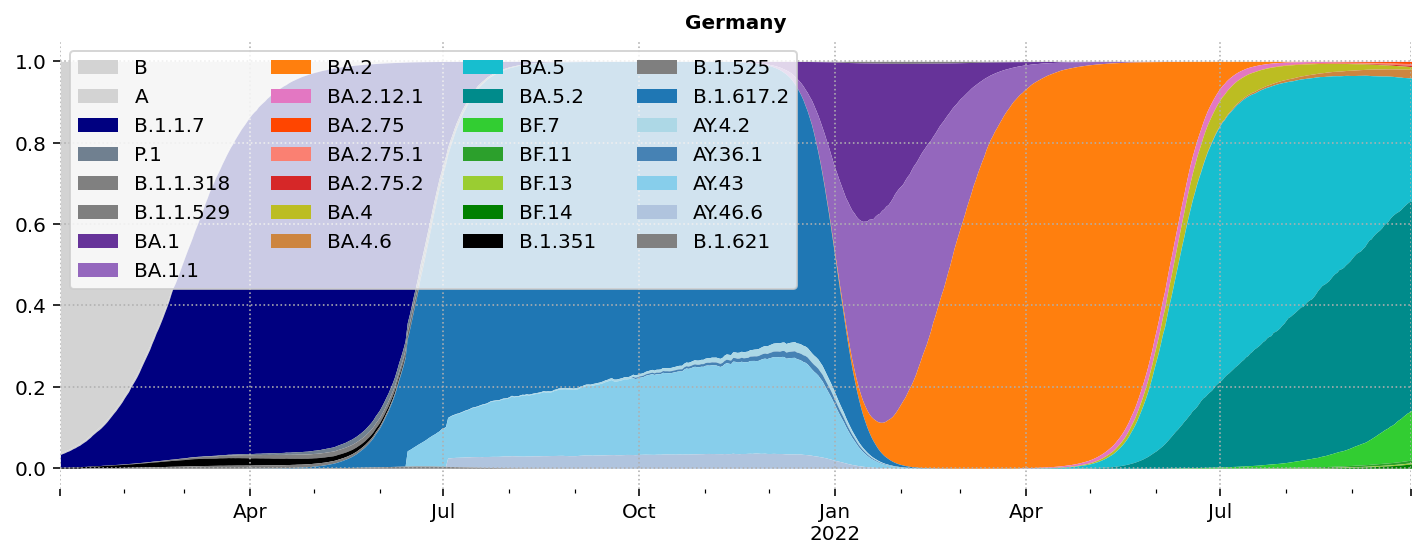

In [109]:
fig, ax = plt.subplots(1,1, figsize=(10,4), sharex=True, sharey=True)
ax = [ax]
#ax = ax.flatten()
#col = ['C7','C3',"C4","C1", "C6","C5","C8" ,"C9", "C7","C0"]
#labels =[alias(x) for x in merged_lineages]
col = lineage_colors #dict(zip(labels, col))
for i,r in enumerate(["Germany"]):
    y = pd.DataFrame(λ[i,:,:]/λ[i].sum(-1, keepdims=True), columns=merged_lineages_alias, index=cases_land.columns[1] + np.arange(λ.shape[1]).astype('timedelta64[D]')) #cases_land.loc[r].loc["2021-12-01":,'AnzahlFall'] / capita[r] * 1000 #* 700
    #y = y.drop(columns=["B.1.1.529","Other"])
    y = y.iloc[:,[i-1  for i in range(y.shape[1])]].iloc[:,::-1].cumsum(1)#* 1000 * 700
    #y.index.name = 'date'
    #x = prop_bl.loc[r,:,:][0].unstack()
    #z = x[0.5] * y
    y["BA.1"].plot(ax=ax[i], ls="", label="")
    #(cases_land.loc[r]/capita[r]*1000 * 700).plot(ax=ax[i], marker=".", markersize=1.3, color="k", ls="", label="")
    for j in range(y.shape[1]-1,-1,-1):
        ax[i].fill_between(y.index, y.iloc[:,j-1] if j > 0 else 0, y.iloc[:,j], color=col[y.columns[j]], alpha=1, lw=0, label=y.columns[j])
    #ax[i].fill_between(y.index, y["BA.2"], y["BA.1"], color='C3', alpha=1, lw=0, label="BA.1")
    #ax[i].fill_between(y.index, y["B.1.617.2"], y["BA.2"], color='C1', alpha=1, lw=0, label="BA.2")
    #ax[i].fill_between(y.index, y["B.1.617.2"], color='C0', alpha=.5, lw=0, label="B.1.617.2")
    #ax[i].fill_between(z.index, y-x[0.95]*y, y-x[0.5]*y, color='none',alpha=1, lw=0, label="Omicron", hatch="//////", edgecolor="C3")
    ax[i].set_title(r, size=10 , weight='bold')
    ax[i].set_xlabel(None)
    #ax[i].set_ylabel("Cases / 7d / 100k")
    ax[i].grid(ls=":")
    #ax[i].set_xlim(("2021-12-01",None))
    #ax[i].set_yscale("log")
    #ax[i].set_ylim((0,100))

    for a in ax[i].spines.values():
        a.set_visible(False)
ax[-1].legend(loc='upper left', title=None, ncol=4)
plt.tight_layout()
#fig.savefig("plots/omi_abs_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

In [110]:
j

0

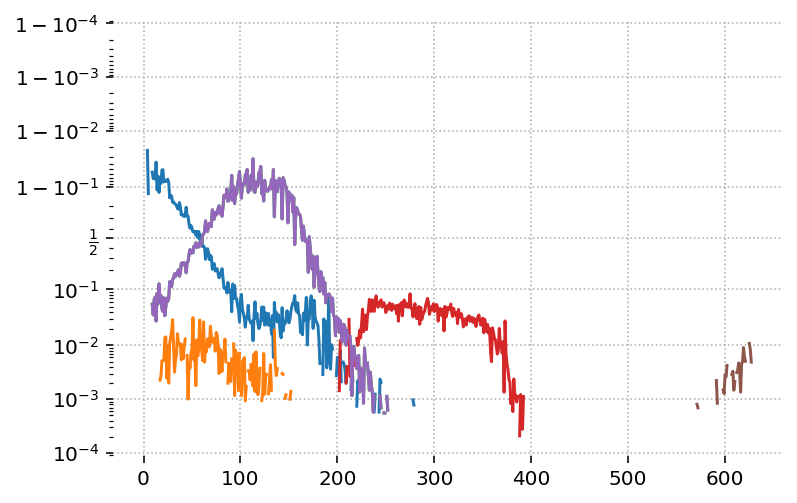

In [111]:
plt.plot(GG[-1,:,-1]/GG[-1].sum(-1))
plt.plot(GG[-1,:,0]/GG[-1].sum(-1))
plt.plot(GG[-1,:,1]/GG[-1].sum(-1))
plt.plot(GG[-1,:,-3]/GG[-1].sum(-1))
plt.plot(GG[-1,:,1]/GG[-1].sum(-1))
plt.plot(GG[-1,:,merged_lineages_alias.index("BF.14")]/GG[-1].sum(-1))
plt.yscale('logit')

In [112]:
dict(zip(merged_lineages_alias,model.posterior['c1'].squeeze().mean(0)))

{'A': -5.6411085,
 'B.1.1.7': -3.7525115,
 'P.1': -9.625613,
 'B.1.1.318': -7.99009,
 'B.1.1.529': -9.37358,
 'BA.1': -6.696161,
 'BA.1.1': -8.972798,
 'BA.2': -12.241489,
 'BA.2.12.1': -5.017369,
 'BA.2.75': -9.142902,
 'BA.2.75.1': -7.062373,
 'BA.2.75.2': -1.32993,
 'BA.4': -12.071831,
 'BA.4.6': -10.260397,
 'BA.5': -9.89735,
 'BA.5.2': -14.89351,
 'BF.7': -4.9145403,
 'BF.11': -4.279432,
 'BF.13': -1.1632204,
 'BF.14': -5.304563,
 'B.1.351': -6.1929035,
 'B.1.525': -7.0441146,
 'B.1.617.2': -8.877759,
 'AY.4.2': -7.265328,
 'AY.36.1': -5.686384,
 'AY.43': -3.2730095,
 'AY.46.6': -3.8278806,
 'B.1.621': -8.632096,
 'B': 0.0}

In [113]:
1/(1+np.exp(-2))

0.8807970779778823

In [114]:
c = model.posterior['c1'].mean(0)
b = model.posterior['b1'].mean(0)
c.shape

(1, 1, 29)

In [115]:
b.shape

(1, 1, 29)

In [116]:
t,g = model.clock()

In [117]:
l0 = t * b + g + c

(-20.0, 100.0)

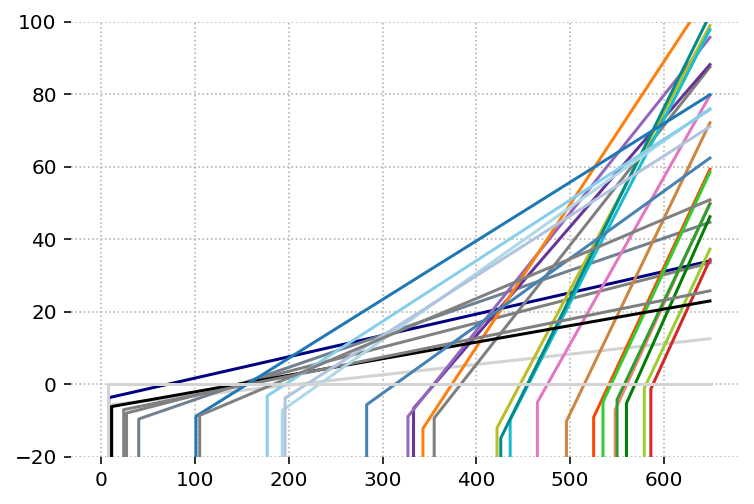

In [118]:
for i in range(l0.shape[-1]):
    plt.plot(l0[0,...,i], c=lineage_colors[merged_lineages_alias[i]])
plt.ylim((-20,100))


In [119]:
lb = np.einsum('ji,jil->jl',
                    logsumexp(l0, -1), #jnp.max(logits,-1),
                    (t==0) * (g==0))

In [120]:
lb

array([[3.4763448e-02, 2.3187790e-02, 1.5935364e-01, 7.9577282e-02,
        3.2251614e+01, 2.8689129e+01, 2.7717558e+01, 3.0308435e+01,
        5.0065266e+01, 6.0341534e+01, 6.8548332e+01, 8.3512497e+01,
        4.3101429e+01, 5.5087132e+01, 4.5368668e+01, 4.3749207e+01,
        6.3548649e+01, 6.9333580e+01, 8.0754326e+01, 7.3268890e+01,
        2.9591179e-02, 6.7408547e-02, 1.9278833e+00, 7.4756327e+00,
        2.0593273e+01, 6.3106689e+00, 7.7362146e+00, 2.1309664e+00,
        0.0000000e+00]], dtype=float32)

(-20.0, 100.0)

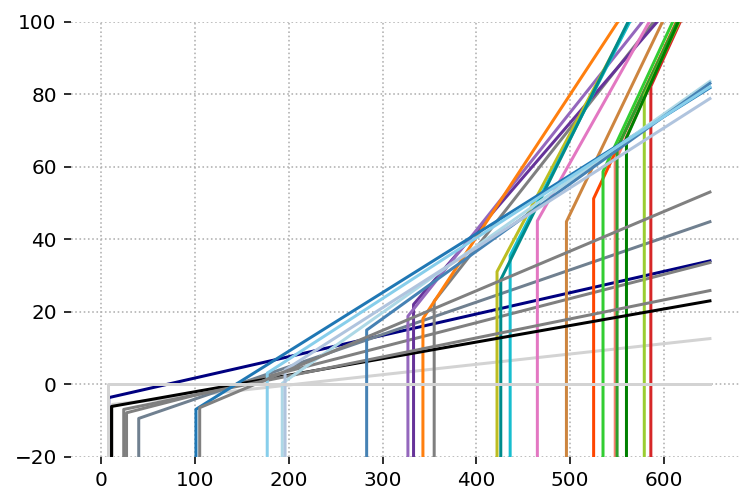

In [121]:
for i in range(l0.shape[-1]):
    plt.plot(l0[0,...,i]+lb[0,i], c=lineage_colors[merged_lineages_alias[i]])
plt.ylim((-20,100))

In [122]:
bak.loc[bak.index.str.startswith("B.1"),:]

,counts,date
B.1.1.7,97128,2021-01-11
B.1.617.2,20390,2021-04-12
B.1.177.86,3505,2021-01-08
B.1.177.81,3064,2021-01-08
B.1.177,2792,2021-01-04
B.1,2519,2021-01-06
B.1.221,2370,2021-01-05
B.1.160,2077,2021-01-04
B.1.351,1941,2021-01-18
B.1.1,1915,2021-01-06
